##Imports

In [267]:
import re
import nltk
import time
import torch
import pickle
import string
import random
import joblib
import argparse
import itertools
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from itertools import cycle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
from torch import optim
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torchtext.legacy.data import Field, LabelField, Dataset, Example, BucketIterator
from google.colab import drive
drive.mount('/content/drive')
from sklearn import metrics

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Saving and Loading models using joblib 

In [268]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [269]:
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)

#Plotting functions

## Finding confusion matrix 

In [270]:
def confusion_matrix_find(y, y_hat, nclasses):
    y = y.astype(np.int64)
    y_hat = y_hat.astype(np.int64)

    conf_mat = np.zeros((nclasses, nclasses))

    for i in range(y_hat.shape[0]):
        true, pred = y[i], y_hat[i]
        conf_mat[true, pred] += 1

    return conf_mat

## Plotting confusion matrix

In [271]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def confusion_matrix_plot(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7)):
    cm = cm.astype(np.int64)
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## ROC curve Plotting functions

In [272]:
#https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
def plot_roc(classes, y_test, y_score, figsize=(7,7)):
  n_classes = len(classes)
  # Plot linewidth.
  lw = 2

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(1)
  plt.figure(figsize=figsize)
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()


## Plot Multi line between all the models

In [273]:
def plot_multi_line_graph(X, listModel,title,y_name, f_size=(7,5)):
  fig = plt.figure(figsize=f_size)
  plt.subplot(111)
  plt.title(title)
  plt.ylabel(y_name)
  plt.xlabel('Epochs')
  for entry in listModel:
    plt.plot(X,entry[0], label=entry[1] , color=entry[2])
  plt.show()


In [274]:
def plot_double_line_graph(X1,Y1,label1 ,X2 ,Y2,label2 ,title,y_name, f_size=(7,5)):
  fig = plt.figure(figsize=f_size)
  plt.subplot(111)
  
  plt.plot(X1,Y1 ,label=label1 ,marker = "x" , color="blue")
  plt.plot(X2, Y2 , label=label2 ,marker = "x" , color="red")
  plt.title(title)
  plt.ylabel(y_name)
  plt.xlabel('Epochs')  
  plt.legend( loc='upper left',prop={'size': 13})
  plt.show()


In [275]:
def plot_single_line_graph(X1,Y1,label1, title,name_y, f_size=(7,5)):
  fig = plt.figure(figsize=f_size)
  plt.subplot(111)
  
  plt.plot(X1,Y1 ,label=label1 ,marker = "x" , color="blue")
  plt.title(title)

  plt.ylabel(name_y)
  plt.xlabel('Epochs')  
  plt.legend( loc='lower right',prop={'size': 13})
  plt.show()


## Generate Report

In [276]:
def generate_report(train_acc, test_acc, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test, enc):
  def generate_label():
    if args.pooling_strat == 'max':
      return 'MAX-Pooling'
    elif args.pooling_strat == 'local':
      return f'Local {args.pooling_filter_size}-Region Pooling'
    elif args.pooling_strat == 'k-max':
      return f'{args.pooling_k_size}-MAX-Pooling'
    elif args.pooling_strat == 'local-average':
      return f'Local-{args.pooling_filter_size}-AVG-Pooling'
  print(metrics.classification_report(true_test, pred_test, digits=3))
  print(metrics.classification_report(true_train, pred_train, digits=3))
  e = range(len(train_acc))
  label = generate_label()
  train_acc, test_acc = np.array(train_acc)[:,1], np.array(test_acc)[:,1]
  plot_double_line_graph(e,test_acc,"Val acc" ,e,train_acc,"Train Acc" ,f"ACC VS EPOCHS ({label})","Acc",f_size=(15,10))
  conf_mat_test = confusion_matrix_find(np.array(pred_test), np.array(true_test), 10)
  confusion_matrix_plot(np.array(conf_mat_test), range(args.class_num), title=f'Confusion matrix test ({label})', cmap=plt.cm.Blues, figsize=(11,11))
  conf_mat_train = confusion_matrix_find(np.array(pred_train), np.array(true_train), 10)
  confusion_matrix_plot(np.array(conf_mat_train), range(args.class_num), title=f'Confusion matrix Train ({label})', cmap=plt.cm.Blues, figsize=(11,11))

  train_y_one_hot = enc.fit_transform(np.array(true_train).reshape(len(true_train), -1))
  test_y_one_hot = enc.transform(np.array(true_test).reshape(len(true_test), -1))

  prob_pred_train = [x.detach().numpy() for x in prob_pred_train]
  prob_pred_test = [x.detach().numpy() for x in prob_pred_test]
  plot_roc(range(args.class_num), np.array(train_y_one_hot), np.array(prob_pred_train), (10,10))
  plot_roc(range(args.class_num), np.array(test_y_one_hot), np.array(prob_pred_test), (10,10))

#Load data and properties

## Global variables and arguments

In [277]:
root = '/content/drive/MyDrive/DL/A3/'
dataPath = root + 'data/'
modelPath = root + 'model/'

parser = argparse.ArgumentParser(description='CNN text classifier')
# learning
parser.add_argument('-lr', type=float, default=0.00003, help='initial learning rate [default: 0.00003]')
parser.add_argument('-epochs', type=int, default=150, help='number of epochs for train [default: 100]')
parser.add_argument('-batch-size', type=int, default=64, help='batch size for training [default: 64]')

# model
parser.add_argument('-seed', type=int, default=42, help='the seed value [default: 42]')
parser.add_argument('-tokenizer', type=str, default='spacy', help='the tokenization strategy [default: spacy]')
parser.add_argument('-tokenizer-language', type=str, default='en_core_web_sm', help='the tokenization strategy [default: en_core_web_sm]')
parser.add_argument('-max-len', type=int, default=100, help='the length of each sentence [default: 100]')
parser.add_argument('-max-vocab', type=int, default=5000, help='the max length of the vocab [default: 5000]')
parser.add_argument('-embed-dim', type=int, default=300, help='number of embedding dimension [default: 300]')
parser.add_argument('-out-dim', type=int, default=6, help='the total number of classes [default: 6]')
parser.add_argument('-num-feature-map', type=int, default=100, help='number of kernels of each size [default: 100]')
parser.add_argument('-pooling-strat', type=str, default='max', help='type of pooling [default: max]')

parser.add_argument('-kernel-size-list', type=list, default=[3,4,5], help='comma-separated kernel size to use for convolution')
parser.add_argument('-local-pool-size-list', type=list, default=[3,5,10,15], help='comma-separated pool size to use for local-max')
parser.add_argument('-k-max-pool-size-list', type=list, default=[3,5,10,15], help='comma-separated pool size to use for k- max')
parser.add_argument('-max-norm', type=float, default=3.0, help='l2 constraint of parameters [default: 3.0]')
parser.add_argument('-dropout', type=float, default=0.5, help='the probability for dropout [default: 0.5]')

# device
parser.add_argument('-device', type=int, default=-1, help='device to use for iterate data, -1 mean cpu [default: -1]')
parser.add_argument('-no-cuda', action='store_true', default=False, help='disable the gpu')


_StoreTrueAction(option_strings=['-no-cuda'], dest='no_cuda', nargs=0, const=True, default=False, type=None, choices=None, help='disable the gpu', metavar=None)

In [278]:
args, unknown = parser.parse_known_args()
args.cuda = (not args.no_cuda) and torch.cuda.is_available(); del args.no_cuda
#args.pooling_strat = 'local'
#args.pooling_strat = 'k-max'
#args.pooling_strat = 'local-average'
device = torch.device('cuda' if args.cuda else 'cpu')
print(args)
print(device)

Namespace(batch_size=64, cuda=True, device=-1, dropout=0.5, embed_dim=300, epochs=150, k_max_pool_size_list=[3, 5, 10, 15], kernel_size_list=[3, 4, 5], local_pool_size_list=[3, 5, 10, 15], lr=3e-05, max_len=100, max_norm=3.0, max_vocab=5000, num_feature_map=100, out_dim=6, pooling_strat='max', seed=42, tokenizer='spacy', tokenizer_language='en_core_web_sm')
cuda


#Understanding the dataset

##text  to csv

In [279]:
# file = open(dataPath+'Trec_Train_dataset.txt', "r",encoding = "ISO-8859-1")
# samples = [text.split(' ', 1) for text in file]

# for s in samples:
#   s[0] = s[0].split(':')[0]
  
# dataset = pd.DataFrame(samples, columns=['label','text'])
# dataset.to_csv(dataPath+'dataset.csv', index=False)

## Load the dataset and glove

In [280]:
df = pd.read_csv(dataPath+'dataset.csv')
#g_embedding = load(dataPath+'glove.pkl')
df

,label,text
0,2,What chess outcome results when a player has n...
1,4,"What river runs through Colorado , Kansas , an..."
2,4,"What country , after Canada and Mexico , is cl..."
3,1,What is the history of `` the toast '' ?\n
4,1,What are liver enzymes ?\n
...,...,...
5447,3,Who starred with Charlie Chaplin in Modern Tim...
5448,3,What famous model was married to Billy Joel ?\n
5449,3,Woodrow Wilson served as president of what uni...
5450,4,Where can I find examples of legal cases about...


##Label encoder

In [281]:
unique_labels = df.label.unique()
le = LabelEncoder()
x = le.fit(unique_labels)
print(x.classes_)

[0 1 2 3 4 5]


## Save labelencoder

In [282]:
save(modelPath+'labelEncoder.pkl',le)
le = load(modelPath+'labelEncoder.pkl')

## label encode the dataset

In [283]:
df['label'] = le.transform(df.label)
df.to_csv(dataPath+'dataset.csv', index=False)  

##Train Test split

In [284]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=args.seed)
print(X_train.head())

4044    What attorney-general ordered the closing of A...
2658                       Who designed London Bridge ?\n
2591    Who was the only person convicted in the My La...
1634          What kind of animal was Winnie the Pooh ?\n
596     What former president 's daughter has written ...
Name: text, dtype: object


# Pytorch and Torchtext data

## Initialize text and field and preprocess text

### Utils

In [285]:
def inputPreprocess(documentText):
  #Convert the text to lower case
  documentText = documentText.lower()
  documentText = documentText.replace(',',' , ').replace(',','')
  #removing punctuations from the string
  documentText = documentText.translate(str.maketrans('','',string.punctuation))

  #Perform word tokenization
  listToken = word_tokenize(documentText)
  stopWords = set(stopwords.words('english'))  
    
  #removing stopwords from tokens
  filtered_sentence = [token for token in listToken if token not in stopWords and token not in ['', ' ']]
  #removing single char word and \x type chars
  filtered_sentence = [token for token in listToken if len(token) > 1 and '\\x0' not in token]
  return filtered_sentence

def get_pad_to_min_len_fn(min_length):
  def pad_to_min_len(batch, vocab, min_length=min_length):
      pad_idx = vocab.stoi['<pad>']
      for idx, ex in enumerate(batch):
          if len(ex) < min_length:
              batch[idx] = ex + [pad_idx] * (min_length - len(ex))
      return batch
  return pad_to_min_len

### Load Field and Label

In [286]:
X_train_preprocessed = X_train.apply(lambda x: inputPreprocess(x))
X_test_preprocessed = X_test.apply(lambda x: inputPreprocess(x))

max_length = 0
for text in X_train_preprocessed:
  max_length = max(max_length, len(text))
print(max_length)
min_len_padding = get_pad_to_min_len_fn(min_length=max_length)

for text in X_test_preprocessed:
  max_length = max(max_length, len(text))
print(max_length)
text_field = Field(tokenize='basic_english', lower=True, fix_length=max_length, postprocessing=min_len_padding)
label_field = Field(sequential=False, use_vocab=False)


text_field.build_vocab(
    X_train_preprocessed, 
    max_size = args.max_vocab,
    vectors=g_embedding,
    unk_init = torch.Tensor.normal_
)
label_field.build_vocab(
    df['label']
)

args.embed_num = len(text_field.vocab)
args.class_num = len(label_field.vocab) - 1
print(len(text_field.vocab))
print(args.class_num)

32
32
5002
6


In [287]:
print(df['label'])

0       2
1       4
2       4
3       1
4       1
       ..
5447    3
5448    3
5449    3
5450    4
5451    3
Name: label, Length: 5452, dtype: int64


In [288]:
X_train_preprocessed.iloc[1]

['who', 'designed', 'london', 'bridge']

###Dataframe to Pytorch dataset

In [289]:
class DataFrameDataset(Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )

### Train dataset and Test dataset

In [290]:
train_dataset = DataFrameDataset(
    df=pd.DataFrame(zip(X_train_preprocessed, y_train), columns=['text', 'label']),  
    fields=[
        ('text', text_field),
        ('label', label_field)
    ]
)

test_dataset = DataFrameDataset(
    df=pd.DataFrame(zip(X_test_preprocessed, y_test), columns=['text', 'label']),  
    fields=(
        ('text', text_field),
        ('label', label_field)
    )
)

##Data Iterator 

In [291]:
train_iterator, test_iterator = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), 
    batch_sizes=(args.batch_size, len(test_dataset)),
    sort=False,
    device = device
)

## Length of train and test


In [292]:
print(f'size vocab: {args.embed_num}')
print(f'no of classes: {args.class_num}')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'No of Train batches: {len(train_iterator)}')
print(f'No of Test batches: {len(test_iterator)}')
print(text_field.vocab.itos[5:15])

size vocab: 5002
no of classes: 6
Train dataset size: 4361
Test dataset size: 1091
No of Train batches: 69
No of Test batches: 1
['of', 'in', 'how', 'was', 'who', 'to', 'for', 'are', 'and', 'does']


## Label count

In [293]:
df['label'].value_counts().unique

<bound method Series.unique of 2    1250
3    1223
1    1162
5     896
4     835
0      86
Name: label, dtype: int64>

## Understanding the batch

In [294]:
batch_train = next(iter(train_iterator))
print(batch_train)
print('\n Shape of Training Data ',batch_train.text.T.shape)
print('\nRepresentation of First Sentence ')
print(batch_train.text.flatten())

print('\nRepresentation of Labels')
print(batch_train.label)

batch_test = next(iter(test_iterator))
batch_test.label


[torchtext.legacy.data.batch.Batch of size 64]
	[.text]:[torch.cuda.LongTensor of size 32x64 (GPU 0)]
	[.label]:[torch.cuda.LongTensor of size 64 (GPU 0)]

 Shape of Training Data  torch.Size([64, 32])

Representation of First Sentence 
tensor([3, 3, 3,  ..., 1, 1, 1], device='cuda:0')

Representation of Labels
tensor([2, 1, 1, 4, 2, 2, 3, 2, 3, 5, 1, 4, 2, 5, 1, 0, 5, 1, 1, 5, 2, 1, 4, 4,
        4, 3, 1, 1, 5, 5, 3, 1, 3, 4, 2, 5, 2, 3, 4, 2, 4, 3, 4, 1, 3, 2, 2, 1,
        2, 5, 4, 1, 1, 2, 1, 1, 5, 2, 1, 4, 2, 4, 4, 1], device='cuda:0')


tensor([4, 2, 4,  ..., 2, 4, 2], device='cuda:0')

# Model Implementation

In [295]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self, embedding):
    super().__init__()

    self.embedding = nn.Embedding.from_pretrained(embedding, freeze=False)
    
    self.convs = nn.ModuleList([
                                nn.Conv2d(in_channels = 1, 
                                          out_channels = args.num_feature_map, 
                                          kernel_size = (fs, args.embed_dim)).to(device)
                                for fs in args.kernel_size_list
                                ])
    
    self.dropout = nn.Dropout(args.dropout).to(device)
    
    if args.pooling_strat == 'local' or args.pooling_strat == 'local-average':
      if args.pooling_strat == 'local':
        print(f'{args.pooling_filter_size}-local')
      else:
        print(f'{args.pooling_filter_size}-local-average')
        
      self.fc = nn.Linear(sum([ceil((max_length-fs+1)/args.pooling_filter_size)*args.num_feature_map for fs in args.kernel_size_list]),
                          args.class_num).to(device)
    elif args.pooling_strat == 'k-max':
      print(f'{args.pooling_k_size}-max')
      self.fc = nn.Linear(len(args.kernel_size_list) * args.num_feature_map* args.pooling_k_size, args.class_num).to(device)
    else:
      print('1-max')
      self.fc = nn.Linear(len(args.kernel_size_list) * args.num_feature_map, args.class_num).to(device)
    
  def kmax(self, conv, dim, k):
    index = conv.topk(k, dim = dim)[1]#[0]
    return conv.gather(dim, index)

  def forward(self, text):
    
    #text = [sent len, batch size]
    text = text.permute(1, 0)
    #text = [batch size, sent len]

    embedded = self.embedding(text)       
    #embedded = [batch size, sent len, emb dim]
    
    embedded = embedded.unsqueeze(1)
    #embedded = [batch size, 1, sent len, emb dim]
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
    #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]

    if args.pooling_strat == 'local':
      pooled = [F.max_pool1d(conv, args.pooling_filter_size, ceil_mode=True).squeeze(2) for conv in conved]
      pooled = [pool.reshape(tuple(pool.shape[:-2]) + (pool.shape[-2]*pool.shape[-1],)) for pool in pooled]
    elif args.pooling_strat == 'k-max':
      pooled = [self.kmax(conv, 2, args.pooling_k_size) for conv in conved]
      pooled = [pool.reshape(tuple(pool.shape[:-2]) + (pool.shape[-2]*pool.shape[-1],)) for pool in pooled]
    elif args.pooling_strat == 'local-average':
      pooled = [F.avg_pool1d(conv, args.pooling_filter_size, ceil_mode=True).squeeze(2) for conv in conved]
      pooled = [pool.reshape(tuple(pool.shape[:-2]) + (pool.shape[-2]*pool.shape[-1],)) for pool in pooled]
      #pooled_n = [batch size, n_filters]
    else:
      pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
      #pooled_n = [batch size, n_filters]
    
    concat = self.dropout(torch.cat(pooled, dim = 1))

    return self.fc(concat)

## Utility functions

In [296]:
#https://colab.research.google.com/github/bentrevett/pytorch-sentiment-analysis/blob/master/5%20-%20Multi-class%20Sentiment%20Analysis.ipynb#scrollTo=NrnEXuHNQDNH
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [297]:
def train(model, iterator, optimizer, criterion):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  prob_pred_train, pred_train, true_train =[], [], []
  for batch in iterator:
    optimizer.zero_grad()
    predictions = model(batch.text)
    prob_pred_train.extend(predictions.cpu())
    pred_train.extend(torch.argmax(predictions.cpu(), dim=1))
    true_train.extend(batch.label.cpu())
    loss = criterion(predictions, batch.label)
    acc = categorical_accuracy(predictions, batch.label)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  
  return epoch_loss / len(iterator), epoch_acc / len(iterator), prob_pred_train, pred_train, true_train

def evaluate(model, iterator, criterion):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  prob_pred_test, pred_test, true_test = [], [], []
  with torch.no_grad():
    for batch in iterator:
      predictions = model(batch.text)
      prob_pred_test.extend(predictions.cpu())  
      pred_test.extend(torch.argmax(predictions.cpu(), dim=1))
      true_test.extend(batch.label.cpu())
      loss = criterion(predictions, batch.label)
      acc = categorical_accuracy(predictions, batch.label)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator), prob_pred_test, pred_test, true_test

# Runner function

## Initalize the model

In [298]:
# model = CNN(text_field.vocab.vectors)
# optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=1/3)
# criterion = nn.CrossEntropyLoss().to(device)
# model = model.to(device)
# criterion = criterion.to(device)
#print(f'The model has {count_parameters(model):,} trainable parameters')

In [299]:
def run(model, path=None):
  best_testloss = float('inf')
  train_data, test_data = [], []

  for epoch in range(args.epochs):
    start_time = time.time()
    
    train_loss, train_acc, prob_pred_train, pred_train, true_train = train(model, train_iterator, optimizer, criterion)
    test_loss, test_acc, prob_pred_test, pred_test, true_test  = evaluate(model, test_iterator, criterion)
    train_data.append([train_loss, train_acc])
    test_data.append([test_loss, test_acc])

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if test_loss < best_testloss:
      best_testloss = test_loss
      if path is not None:
        torch.save(model.state_dict(), path)
    if (epoch+1)%10 == 0:
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

  print(f'best test loss: {best_testloss}')
  return train_data, test_data, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test

1-max
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.150 | Train Acc: 65.52%
	 Val. Loss: 1.140 |  Test. Acc: 67.46%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.737 | Train Acc: 78.85%
	 Val. Loss: 0.770 |  Test. Acc: 77.64%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.523 | Train Acc: 84.85%
	 Val. Loss: 0.594 |  Test. Acc: 80.84%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.404 | Train Acc: 88.61%
	 Val. Loss: 0.505 |  Test. Acc: 82.58%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.315 | Train Acc: 91.37%
	 Val. Loss: 0.454 |  Test. Acc: 84.14%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.249 | Train Acc: 93.91%
	 Val. Loss: 0.419 |  Test. Acc: 84.88%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.199 | Train Acc: 95.18%
	 Val. Loss: 0.395 |  Test. Acc: 85.98%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.167 | Train Acc: 96.26%
	 Val. Loss: 0.378 |  Test. Acc: 86.43%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train Acc: 97.17%
	 Val. Loss: 0.365 |  Test. Acc: 86.89%
Epoch: 100 | 

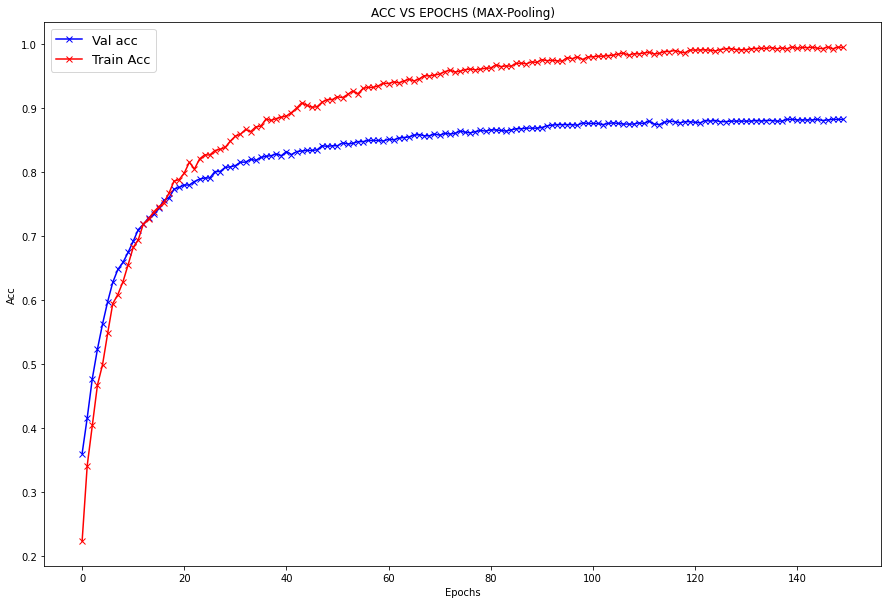

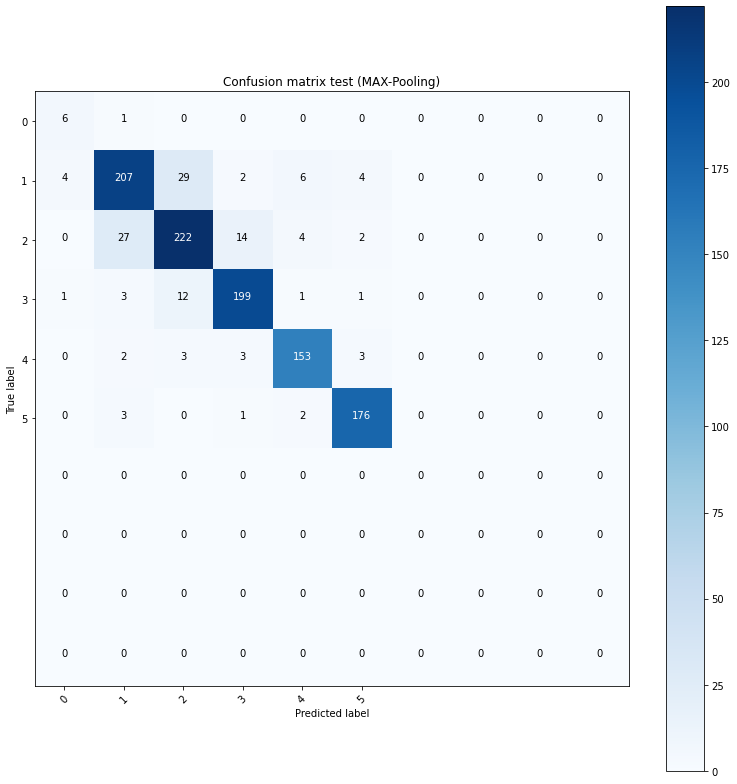

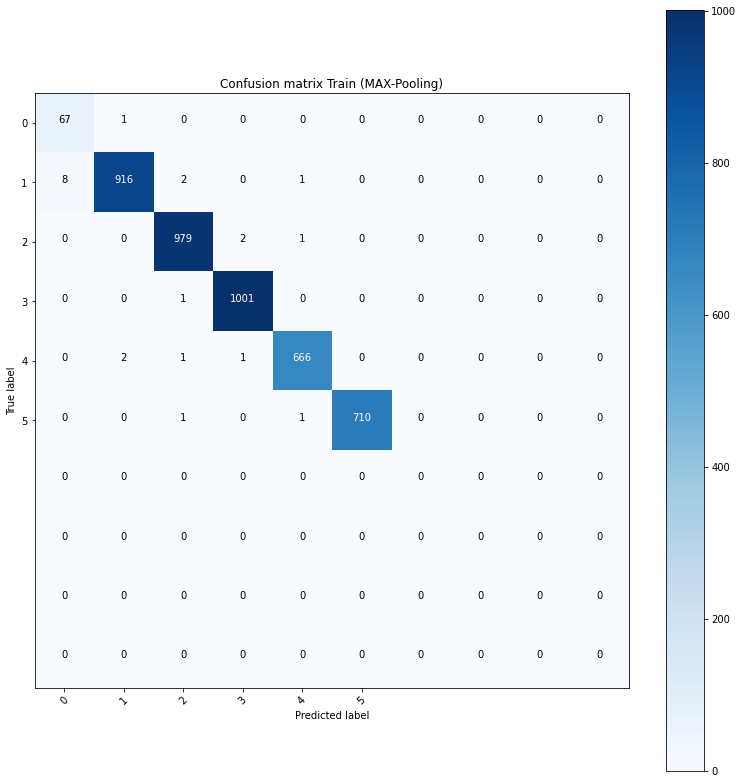

<Figure size 432x288 with 0 Axes>

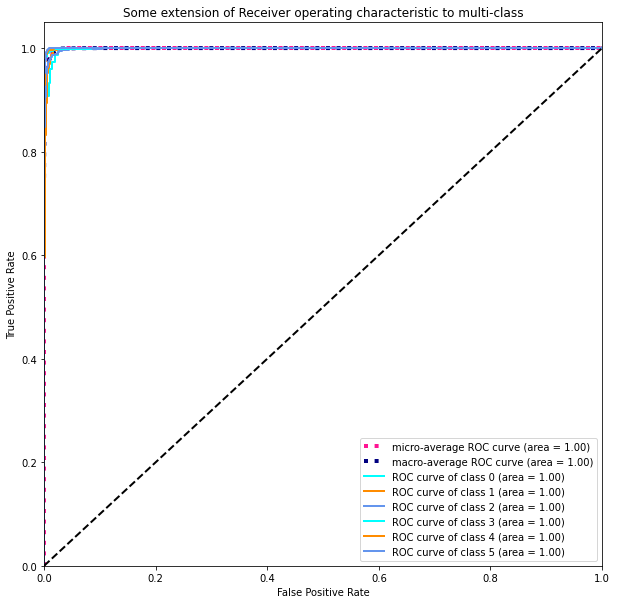

<Figure size 432x288 with 0 Axes>

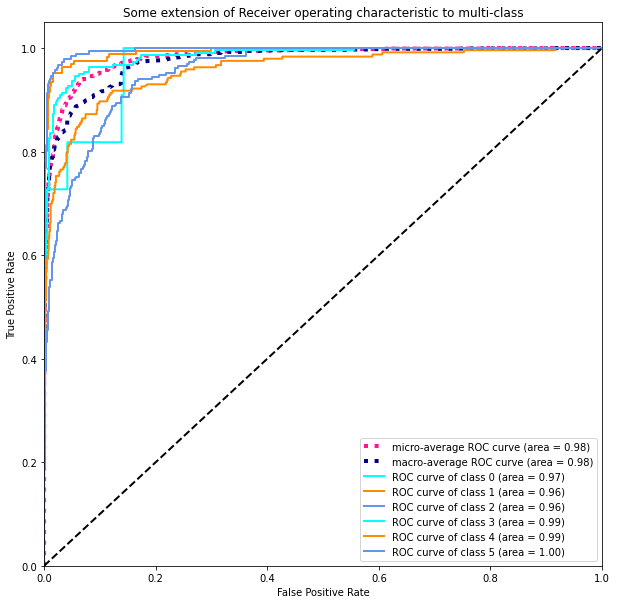

3-local
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.214 | Train Acc: 63.08%
	 Val. Loss: 1.212 |  Test. Acc: 64.44%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.754 | Train Acc: 77.87%
	 Val. Loss: 0.792 |  Test. Acc: 76.35%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.503 | Train Acc: 85.51%
	 Val. Loss: 0.596 |  Test. Acc: 80.38%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.370 | Train Acc: 89.76%
	 Val. Loss: 0.503 |  Test. Acc: 82.77%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.287 | Train Acc: 91.94%
	 Val. Loss: 0.448 |  Test. Acc: 83.87%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.223 | Train Acc: 94.50%
	 Val. Loss: 0.416 |  Test. Acc: 85.15%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.174 | Train Acc: 95.67%
	 Val. Loss: 0.394 |  Test. Acc: 86.34%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train Acc: 97.26%
	 Val. Loss: 0.380 |  Test. Acc: 86.53%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.106 | Train Acc: 97.83%
	 Val. Loss: 0.370 |  Test. Acc: 87.35%
Epoch: 100 

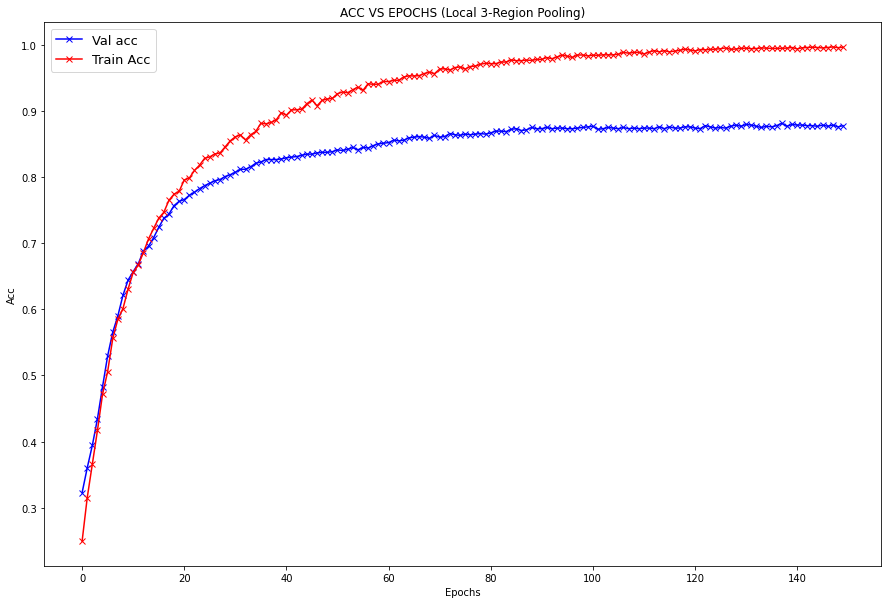

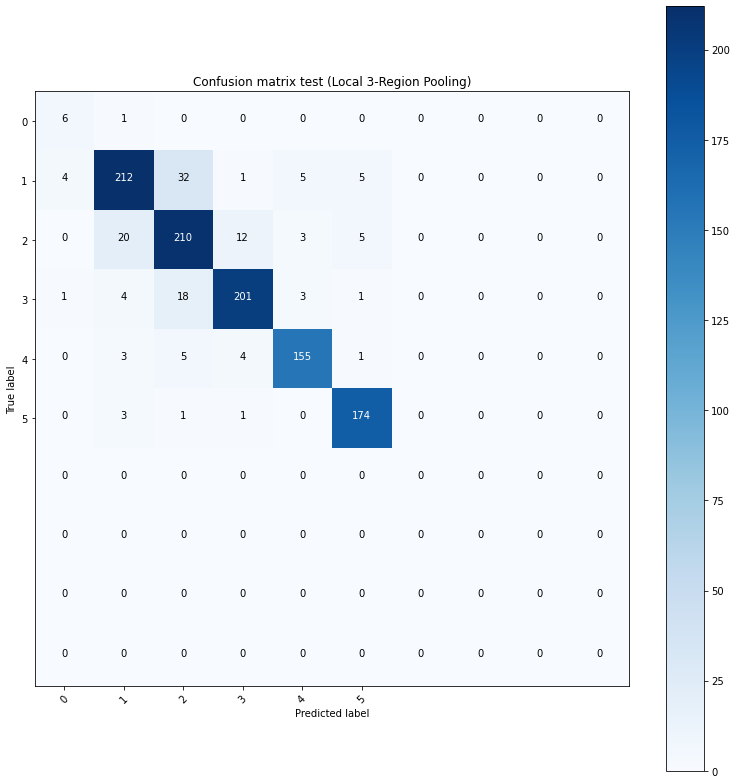

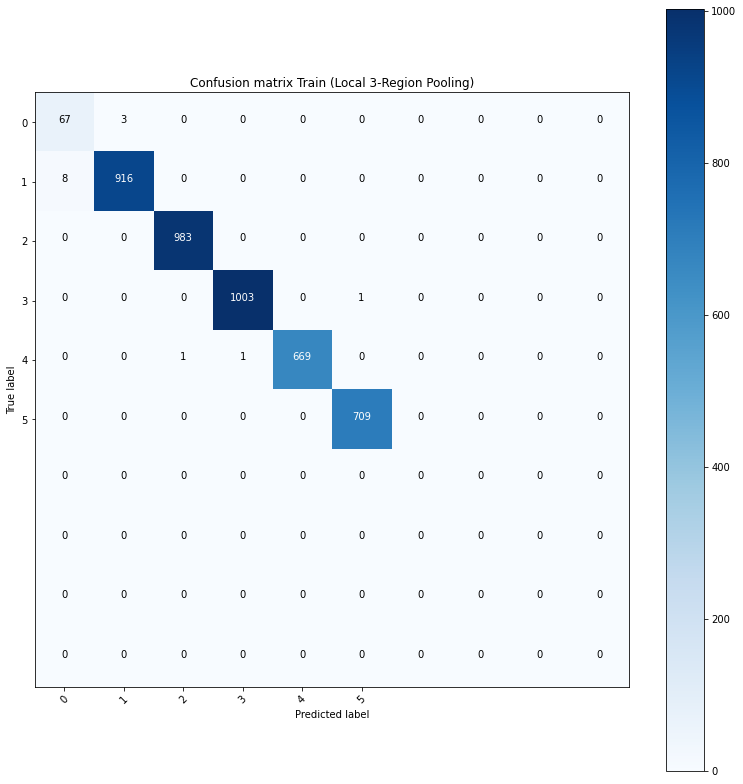

<Figure size 432x288 with 0 Axes>

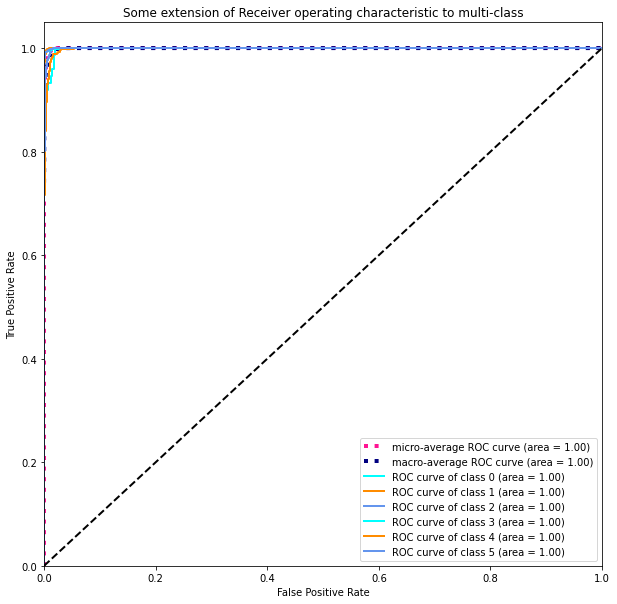

<Figure size 432x288 with 0 Axes>

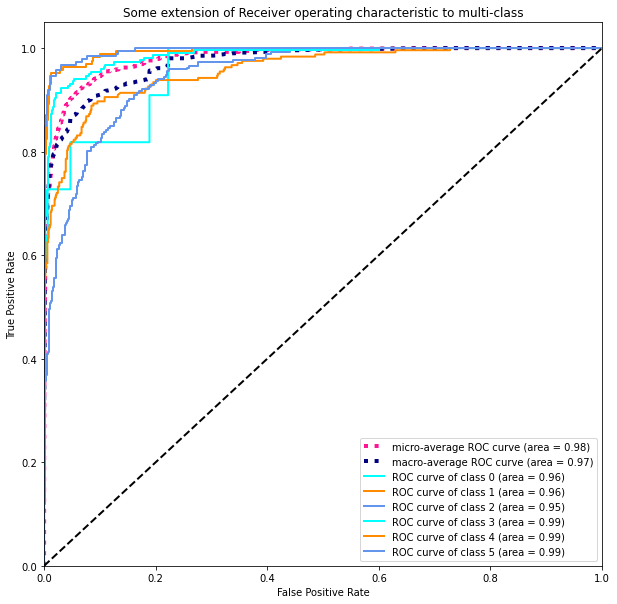

5-local
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.262 | Train Acc: 61.10%
	 Val. Loss: 1.256 |  Test. Acc: 61.32%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.800 | Train Acc: 77.94%
	 Val. Loss: 0.832 |  Test. Acc: 75.25%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.553 | Train Acc: 83.87%
	 Val. Loss: 0.618 |  Test. Acc: 80.66%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.415 | Train Acc: 88.08%
	 Val. Loss: 0.510 |  Test. Acc: 81.76%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.305 | Train Acc: 91.94%
	 Val. Loss: 0.450 |  Test. Acc: 83.87%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.239 | Train Acc: 93.48%
	 Val. Loss: 0.412 |  Test. Acc: 85.24%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.193 | Train Acc: 94.88%
	 Val. Loss: 0.386 |  Test. Acc: 86.25%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.153 | Train Acc: 96.54%
	 Val. Loss: 0.369 |  Test. Acc: 86.80%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.117 | Train Acc: 97.74%
	 Val. Loss: 0.357 |  Test. Acc: 87.35%
Epoch: 100 

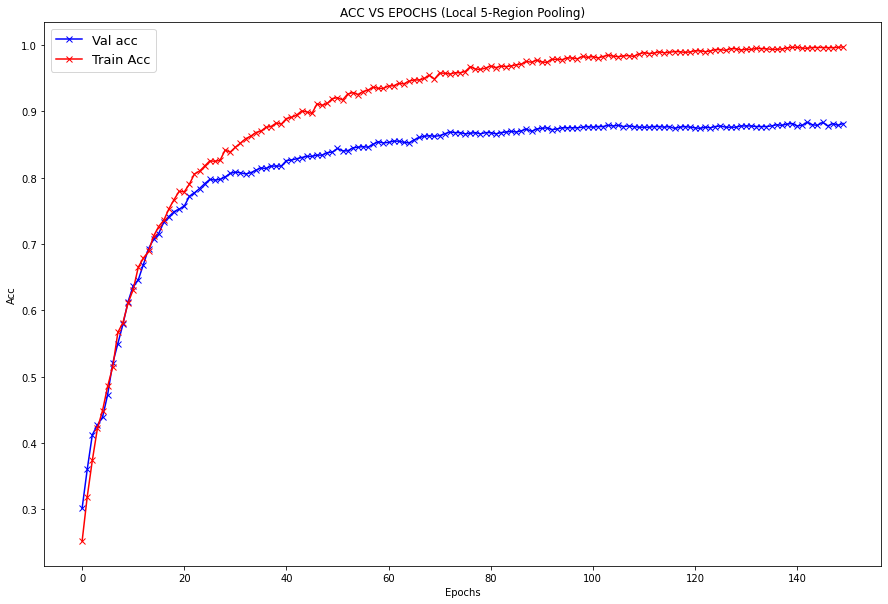

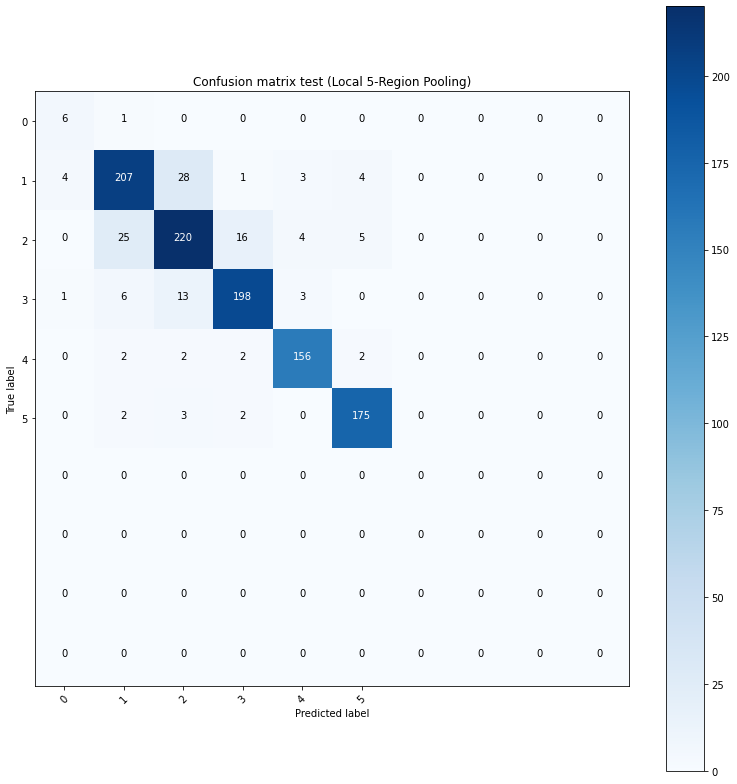

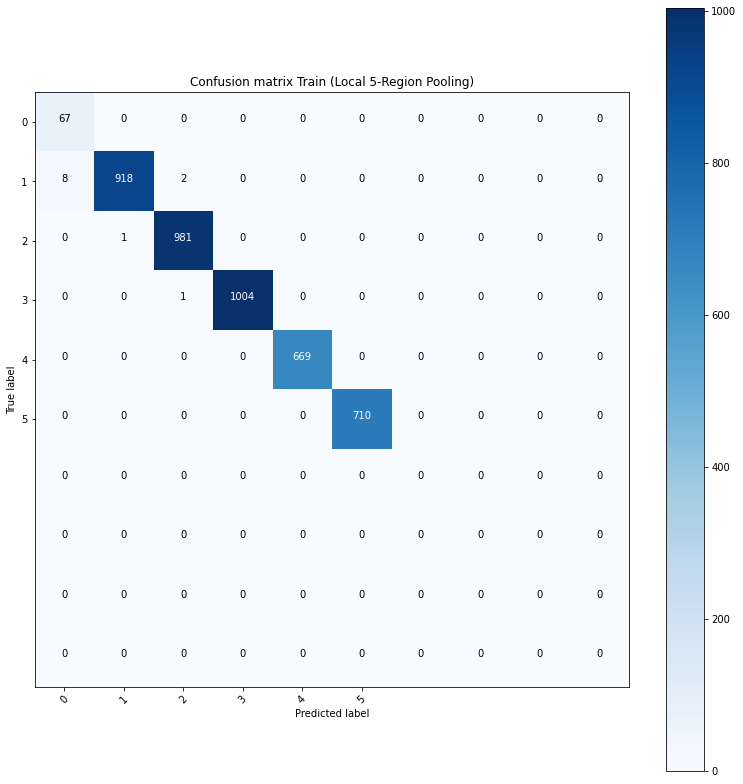

<Figure size 432x288 with 0 Axes>

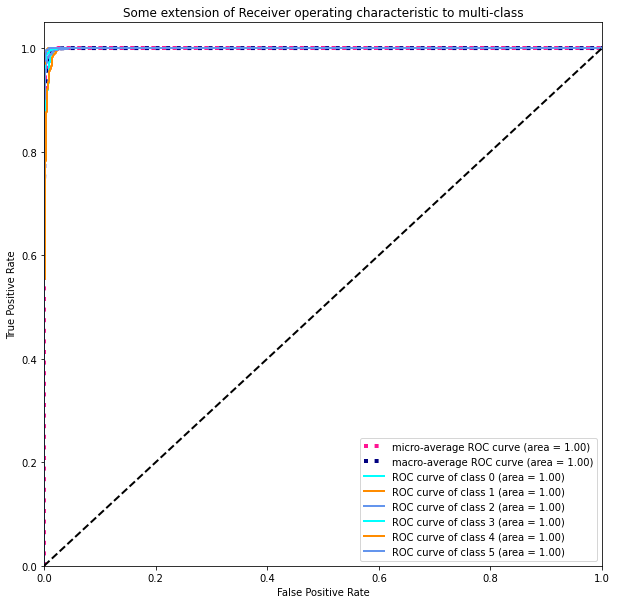

<Figure size 432x288 with 0 Axes>

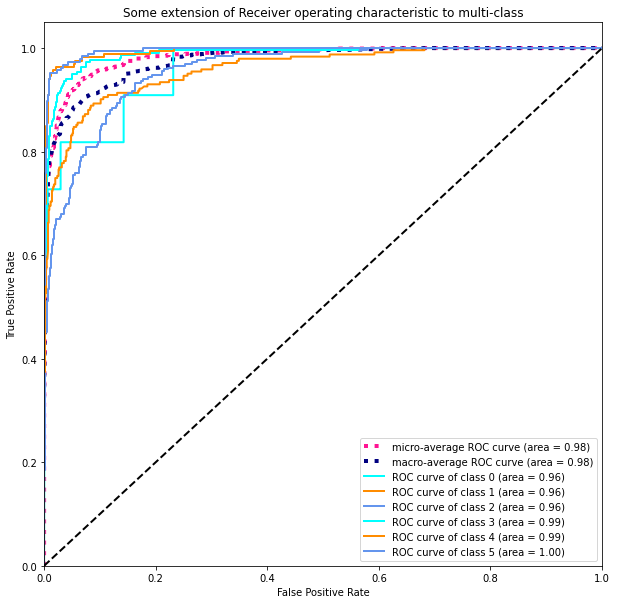

10-local
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.252 | Train Acc: 64.46%
	 Val. Loss: 1.238 |  Test. Acc: 65.44%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.799 | Train Acc: 77.42%
	 Val. Loss: 0.827 |  Test. Acc: 76.44%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.564 | Train Acc: 84.01%
	 Val. Loss: 0.625 |  Test. Acc: 80.57%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.420 | Train Acc: 87.79%
	 Val. Loss: 0.522 |  Test. Acc: 82.86%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.335 | Train Acc: 90.62%
	 Val. Loss: 0.462 |  Test. Acc: 83.87%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.263 | Train Acc: 93.27%
	 Val. Loss: 0.423 |  Test. Acc: 85.43%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.212 | Train Acc: 94.72%
	 Val. Loss: 0.396 |  Test. Acc: 86.16%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.171 | Train Acc: 95.88%
	 Val. Loss: 0.377 |  Test. Acc: 86.80%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.138 | Train Acc: 97.08%
	 Val. Loss: 0.363 |  Test. Acc: 87.08%
Epoch: 100

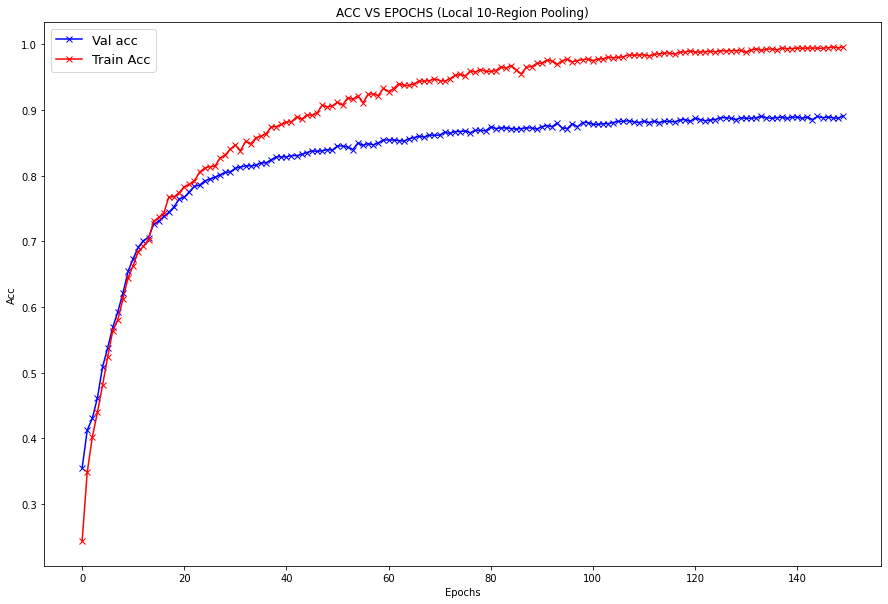

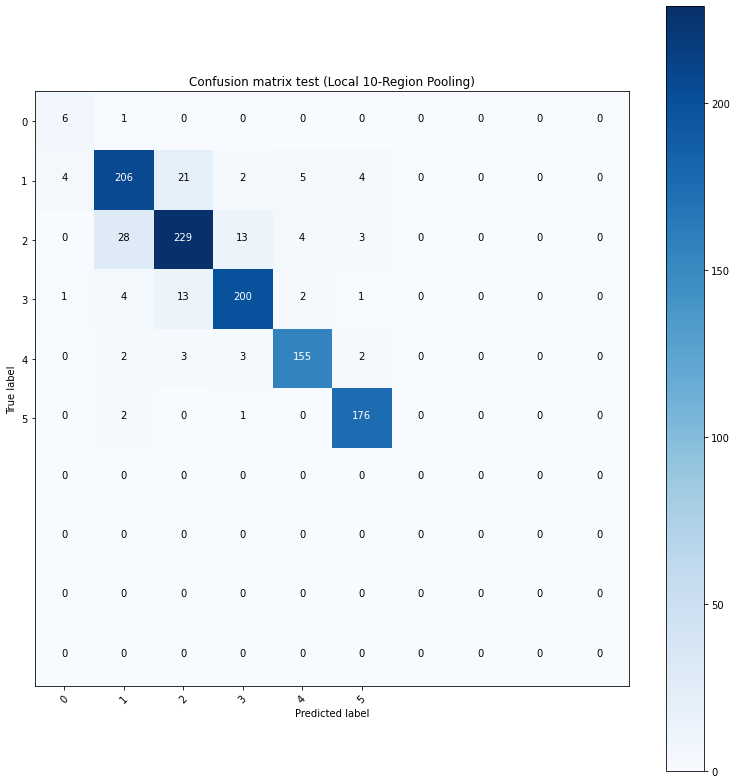

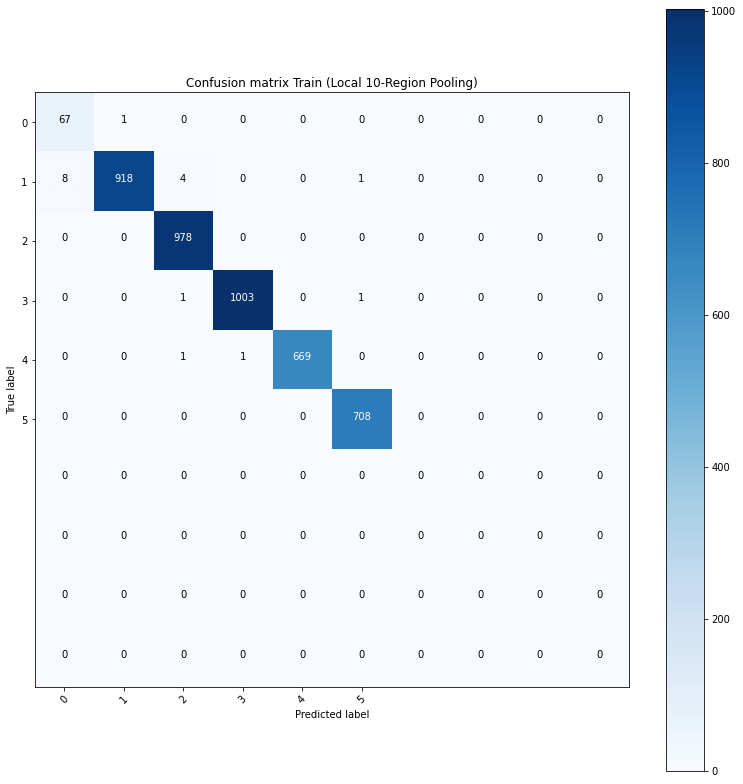

<Figure size 432x288 with 0 Axes>

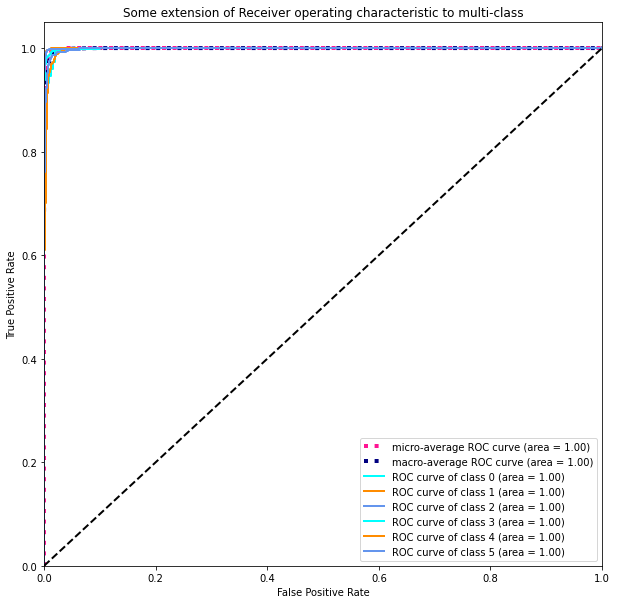

<Figure size 432x288 with 0 Axes>

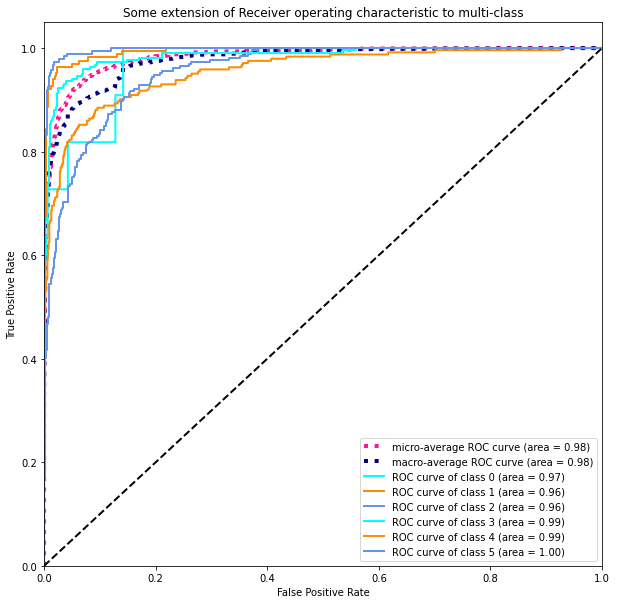

15-local
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.209 | Train Acc: 64.06%
	 Val. Loss: 1.197 |  Test. Acc: 66.73%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.784 | Train Acc: 78.51%
	 Val. Loss: 0.806 |  Test. Acc: 76.72%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.553 | Train Acc: 83.85%
	 Val. Loss: 0.613 |  Test. Acc: 80.75%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.413 | Train Acc: 88.13%
	 Val. Loss: 0.514 |  Test. Acc: 82.49%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.333 | Train Acc: 90.53%
	 Val. Loss: 0.456 |  Test. Acc: 84.05%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.267 | Train Acc: 92.86%
	 Val. Loss: 0.418 |  Test. Acc: 84.97%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.214 | Train Acc: 94.36%
	 Val. Loss: 0.393 |  Test. Acc: 86.43%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.175 | Train Acc: 95.99%
	 Val. Loss: 0.375 |  Test. Acc: 87.17%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.140 | Train Acc: 96.78%
	 Val. Loss: 0.361 |  Test. Acc: 87.72%
Epoch: 100

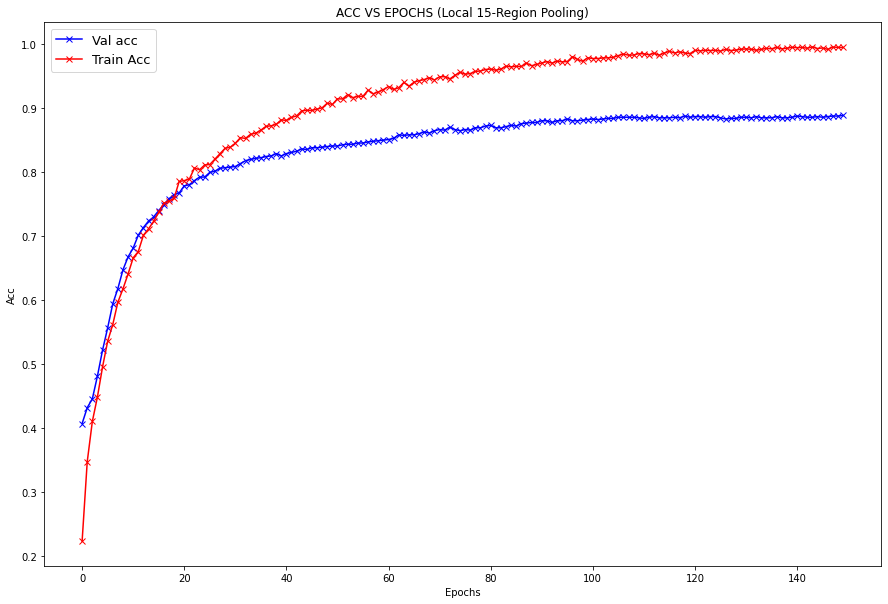

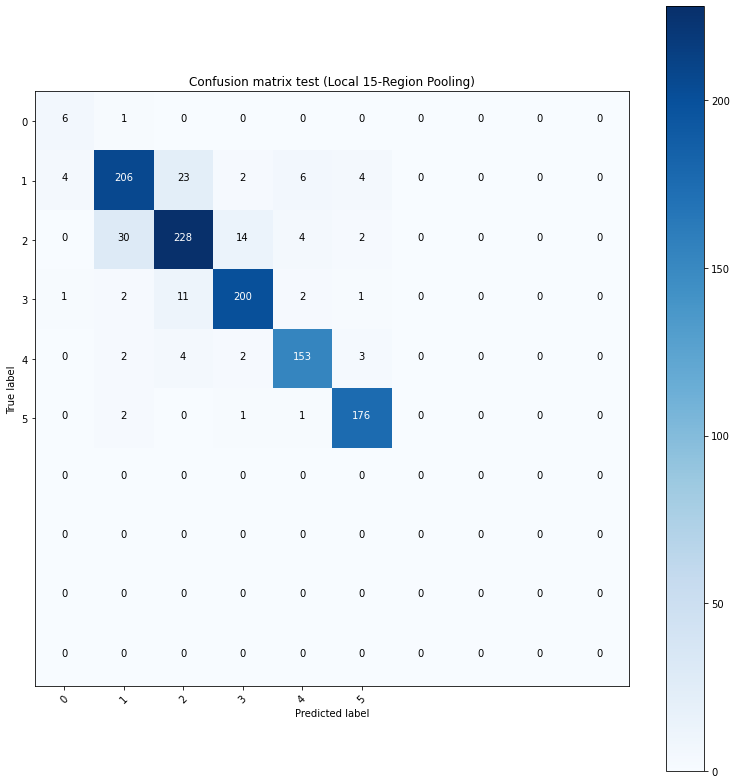

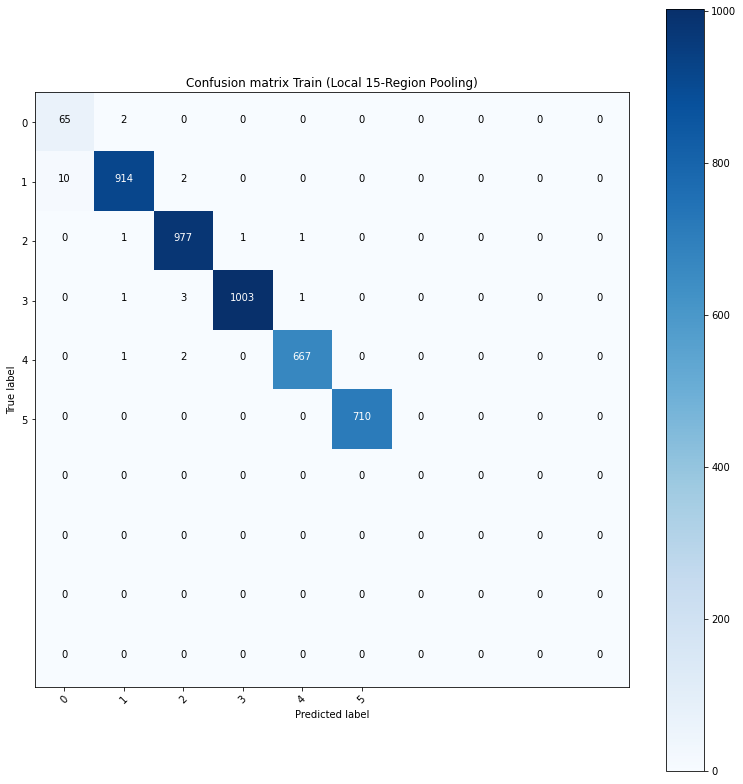

<Figure size 432x288 with 0 Axes>

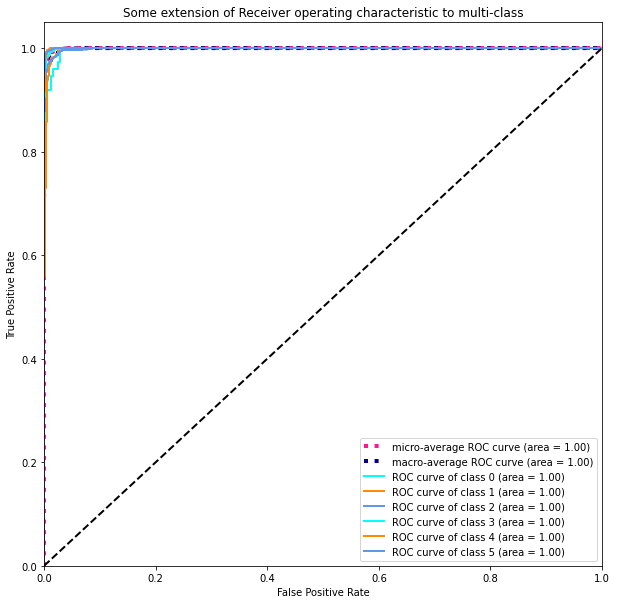

<Figure size 432x288 with 0 Axes>

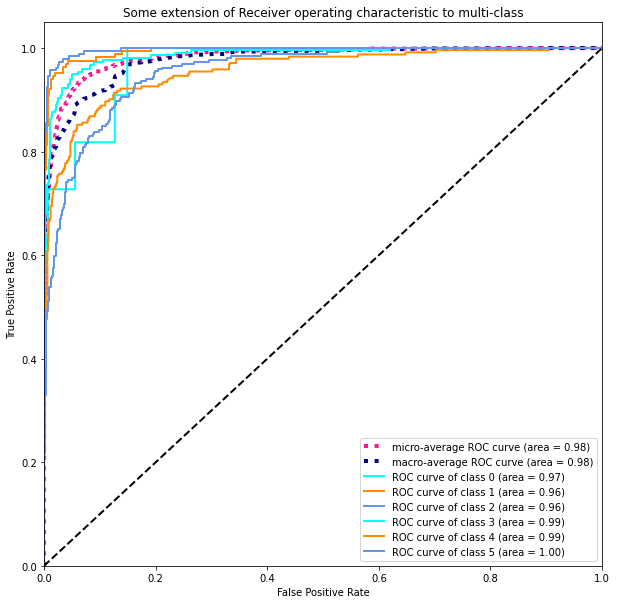

3-max
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.182 | Train Acc: 62.35%
	 Val. Loss: 1.186 |  Test. Acc: 62.33%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.784 | Train Acc: 75.92%
	 Val. Loss: 0.835 |  Test. Acc: 72.78%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.560 | Train Acc: 83.09%
	 Val. Loss: 0.650 |  Test. Acc: 79.10%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.420 | Train Acc: 87.42%
	 Val. Loss: 0.551 |  Test. Acc: 80.75%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.327 | Train Acc: 90.53%
	 Val. Loss: 0.495 |  Test. Acc: 81.58%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.255 | Train Acc: 92.96%
	 Val. Loss: 0.457 |  Test. Acc: 83.68%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.198 | Train Acc: 94.88%
	 Val. Loss: 0.433 |  Test. Acc: 84.42%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.161 | Train Acc: 96.24%
	 Val. Loss: 0.416 |  Test. Acc: 85.15%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.125 | Train Acc: 97.40%
	 Val. Loss: 0.405 |  Test. Acc: 85.33%
Epoch: 100 | 

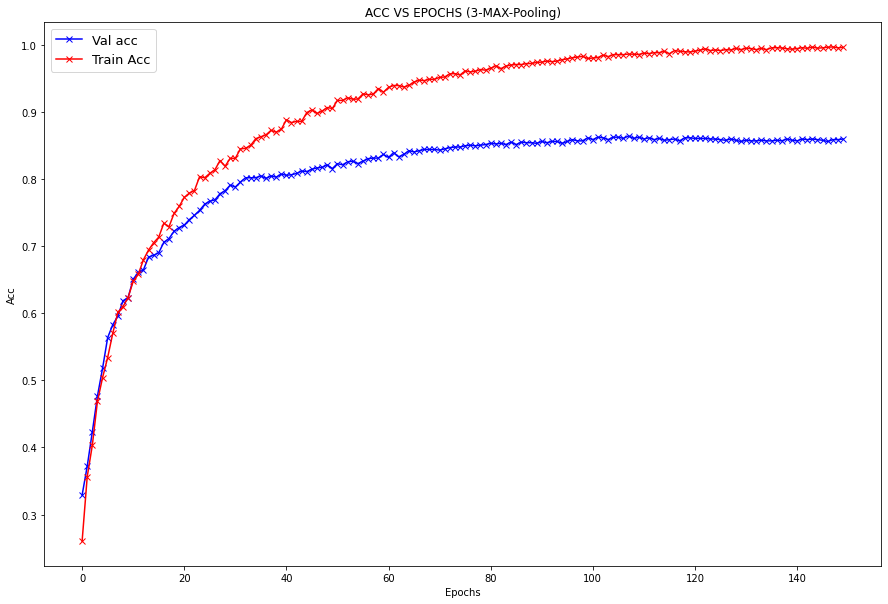

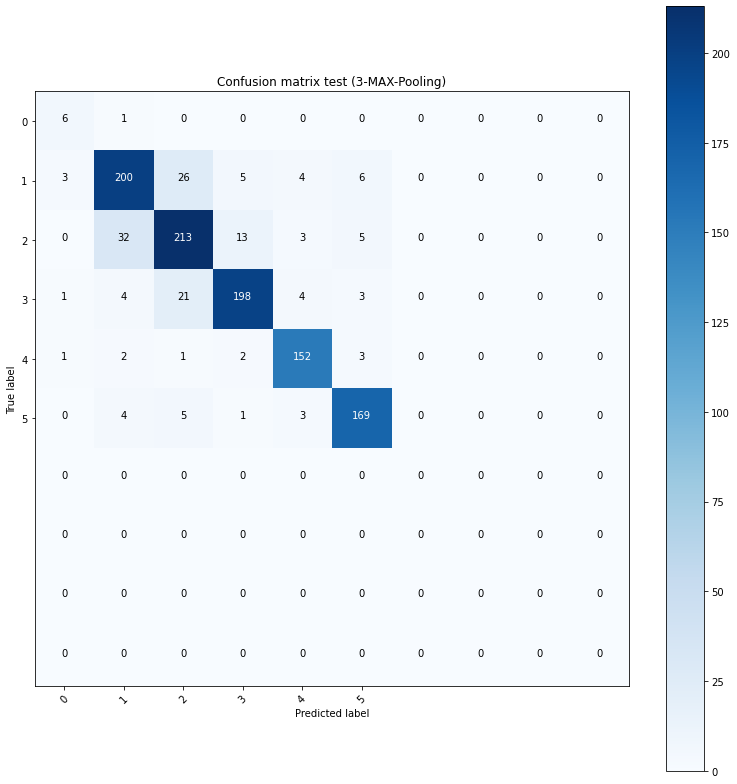

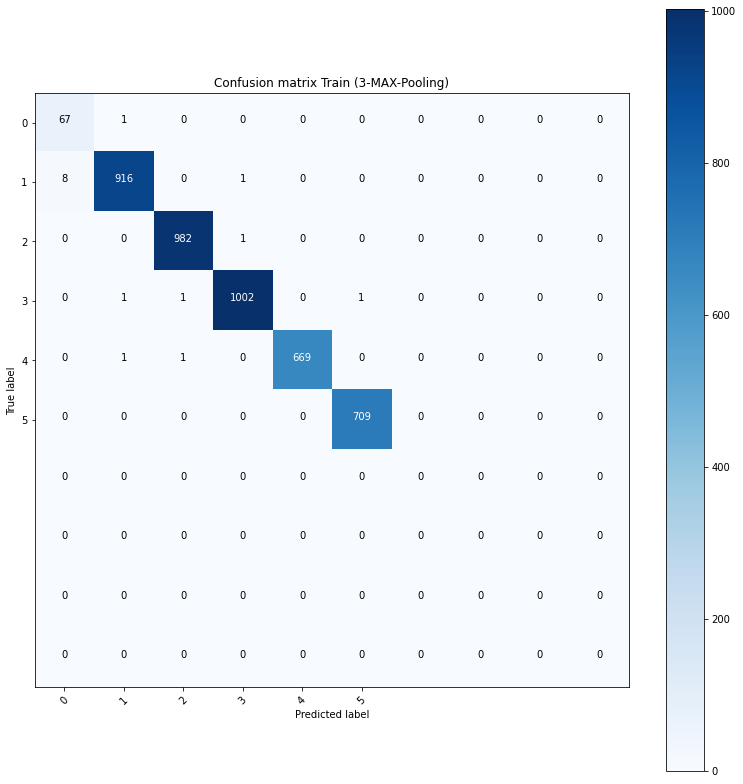

<Figure size 432x288 with 0 Axes>

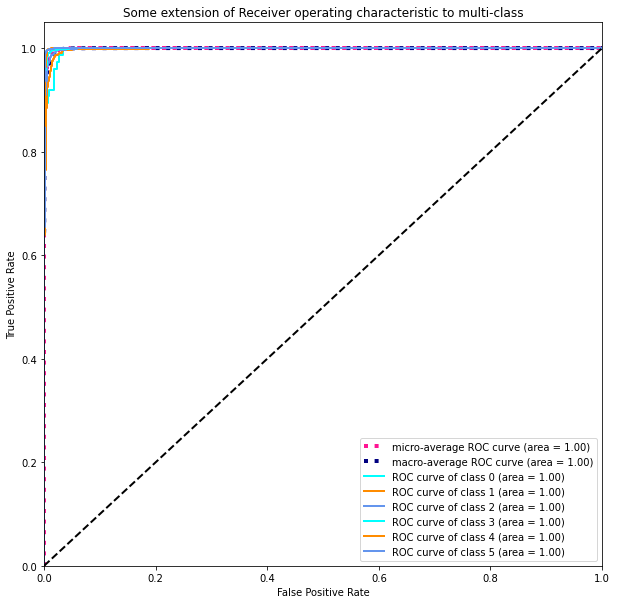

<Figure size 432x288 with 0 Axes>

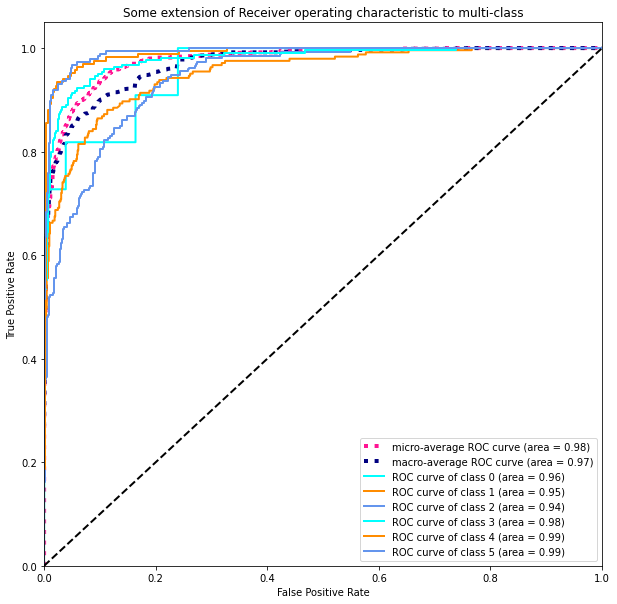

5-max
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.212 | Train Acc: 62.08%
	 Val. Loss: 1.218 |  Test. Acc: 60.68%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.796 | Train Acc: 74.88%
	 Val. Loss: 0.854 |  Test. Acc: 70.76%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.564 | Train Acc: 82.96%
	 Val. Loss: 0.670 |  Test. Acc: 77.64%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.415 | Train Acc: 87.93%
	 Val. Loss: 0.571 |  Test. Acc: 80.48%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.316 | Train Acc: 91.03%
	 Val. Loss: 0.515 |  Test. Acc: 81.76%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.245 | Train Acc: 93.59%
	 Val. Loss: 0.478 |  Test. Acc: 82.22%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.196 | Train Acc: 94.86%
	 Val. Loss: 0.456 |  Test. Acc: 83.13%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.147 | Train Acc: 96.56%
	 Val. Loss: 0.443 |  Test. Acc: 83.87%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.118 | Train Acc: 97.58%
	 Val. Loss: 0.435 |  Test. Acc: 84.60%
Epoch: 100 | 

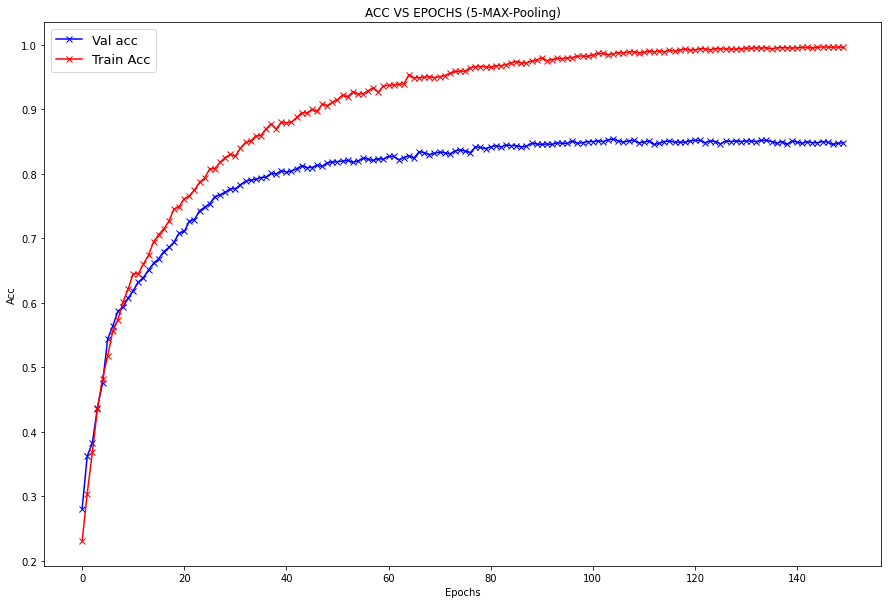

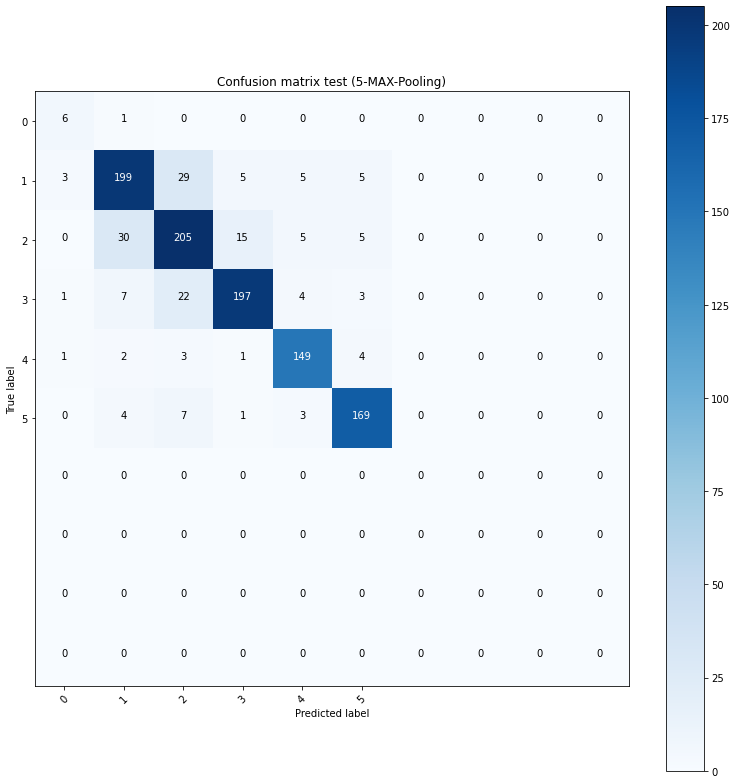

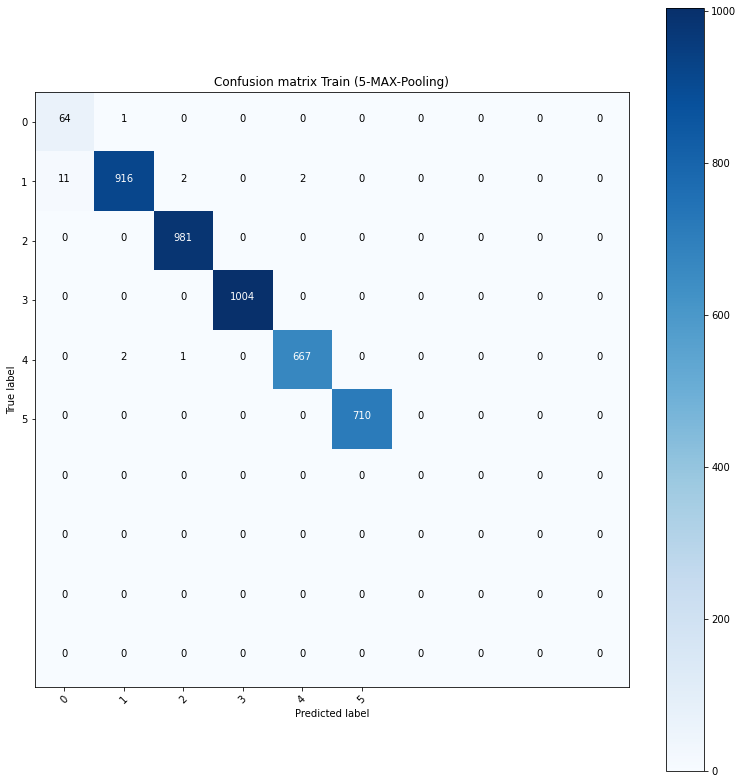

<Figure size 432x288 with 0 Axes>

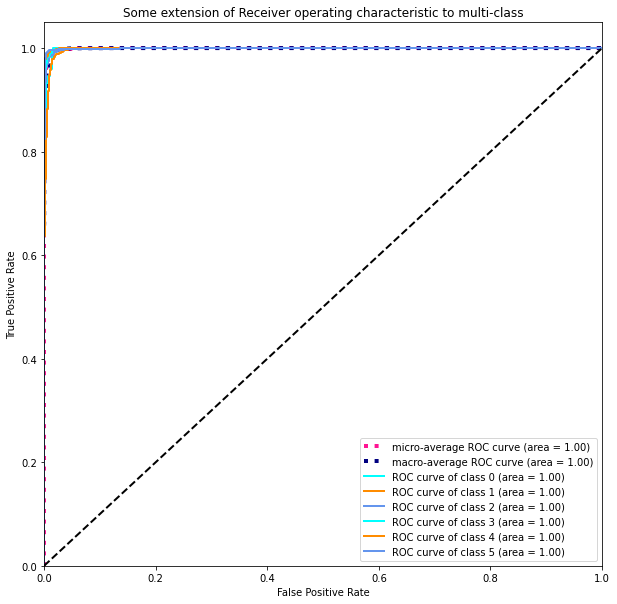

<Figure size 432x288 with 0 Axes>

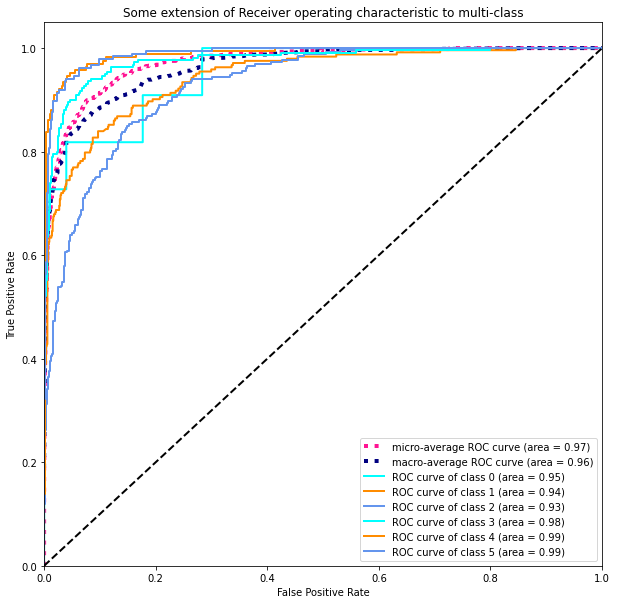

10-max
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.221 | Train Acc: 59.97%
	 Val. Loss: 1.222 |  Test. Acc: 58.20%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.789 | Train Acc: 75.54%
	 Val. Loss: 0.865 |  Test. Acc: 70.21%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.564 | Train Acc: 83.21%
	 Val. Loss: 0.680 |  Test. Acc: 76.72%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.414 | Train Acc: 87.68%
	 Val. Loss: 0.584 |  Test. Acc: 79.01%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.323 | Train Acc: 90.76%
	 Val. Loss: 0.528 |  Test. Acc: 80.93%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.242 | Train Acc: 93.75%
	 Val. Loss: 0.492 |  Test. Acc: 81.94%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.189 | Train Acc: 95.24%
	 Val. Loss: 0.472 |  Test. Acc: 83.59%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.148 | Train Acc: 96.58%
	 Val. Loss: 0.459 |  Test. Acc: 84.23%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.115 | Train Acc: 97.74%
	 Val. Loss: 0.454 |  Test. Acc: 84.42%
Epoch: 100 |

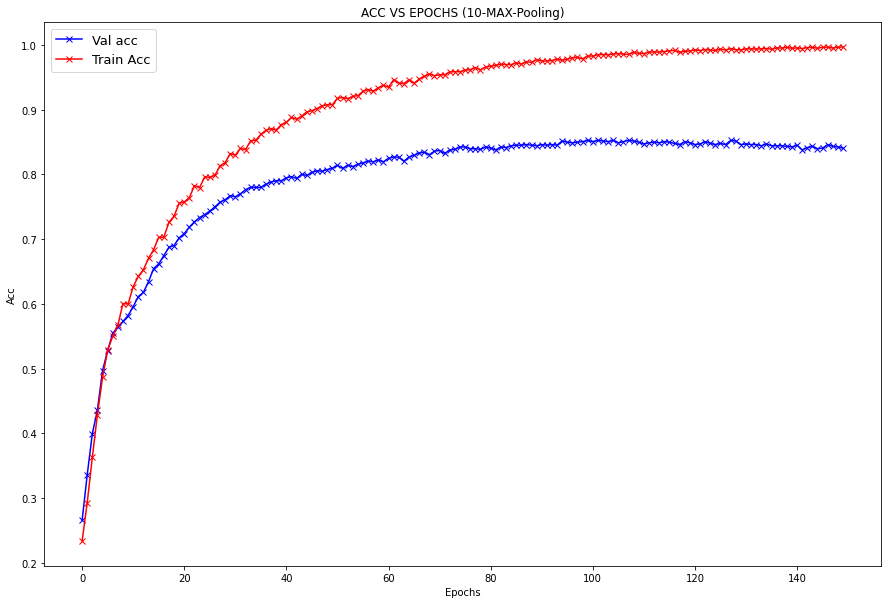

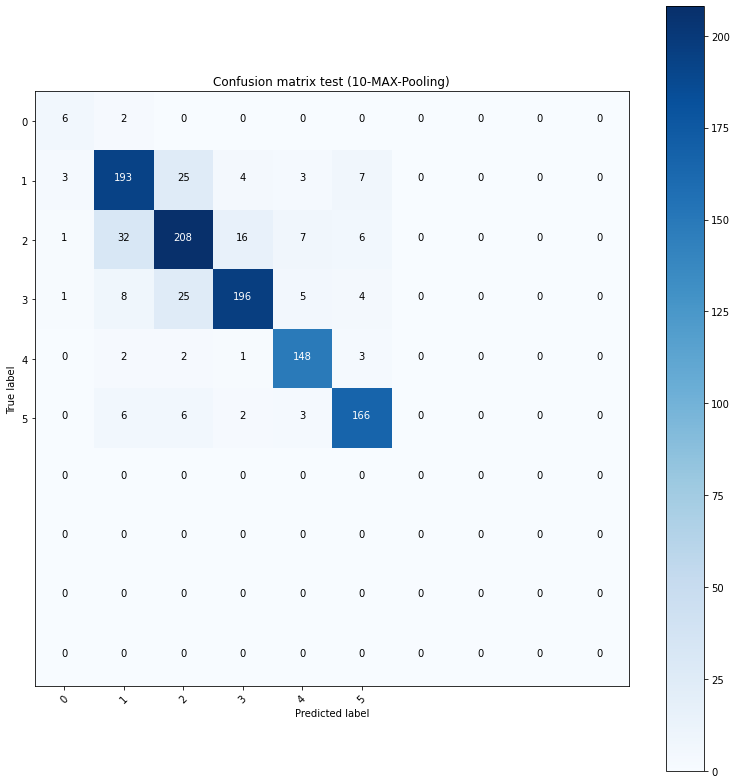

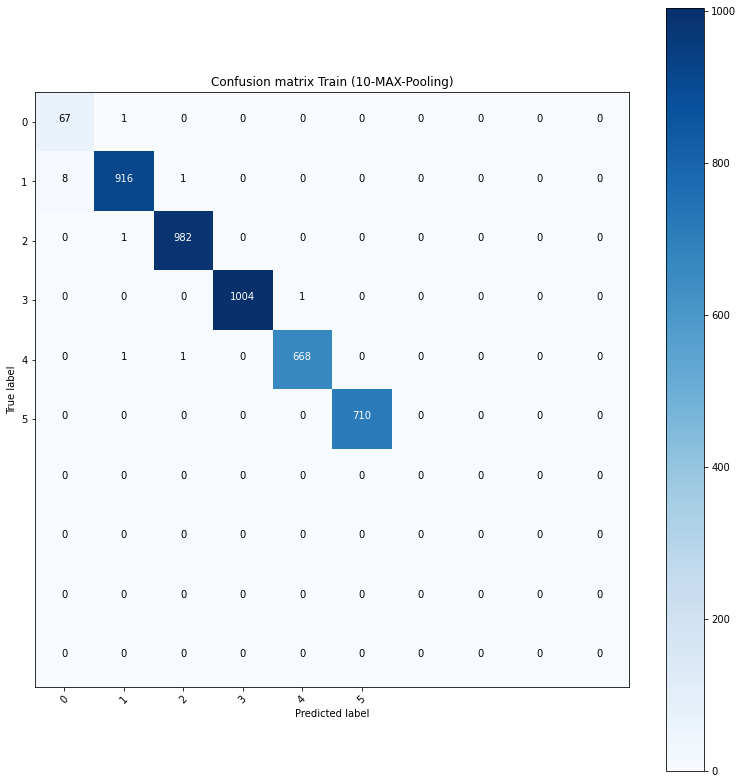

<Figure size 432x288 with 0 Axes>

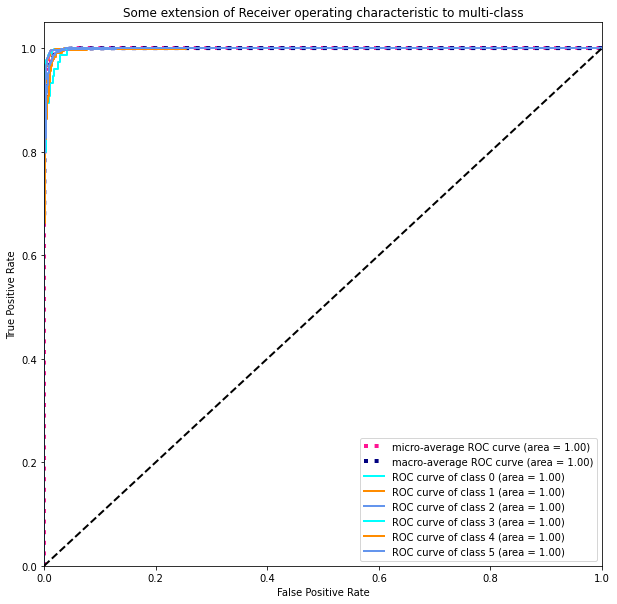

<Figure size 432x288 with 0 Axes>

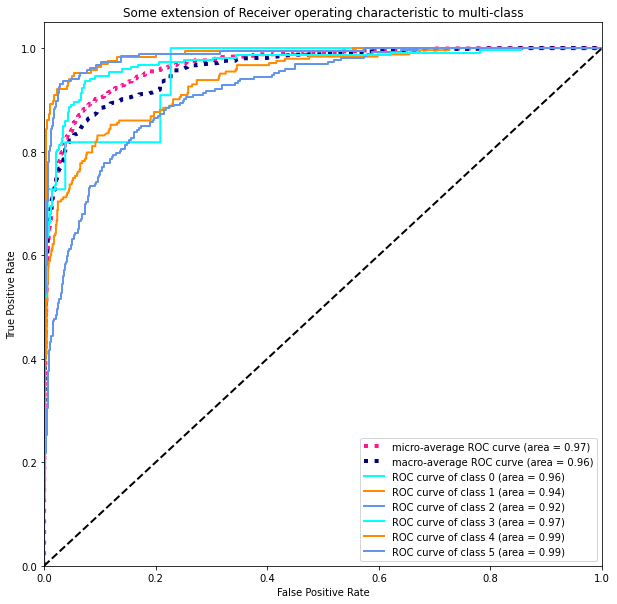

15-max
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.221 | Train Acc: 59.34%
	 Val. Loss: 1.226 |  Test. Acc: 57.84%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.796 | Train Acc: 74.66%
	 Val. Loss: 0.871 |  Test. Acc: 69.94%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.561 | Train Acc: 82.40%
	 Val. Loss: 0.685 |  Test. Acc: 76.54%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.417 | Train Acc: 87.63%
	 Val. Loss: 0.591 |  Test. Acc: 79.10%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.317 | Train Acc: 90.76%
	 Val. Loss: 0.532 |  Test. Acc: 80.84%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.243 | Train Acc: 93.37%
	 Val. Loss: 0.500 |  Test. Acc: 82.03%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.188 | Train Acc: 95.38%
	 Val. Loss: 0.484 |  Test. Acc: 82.95%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.152 | Train Acc: 96.31%
	 Val. Loss: 0.471 |  Test. Acc: 83.87%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.113 | Train Acc: 97.64%
	 Val. Loss: 0.466 |  Test. Acc: 84.60%
Epoch: 100 |

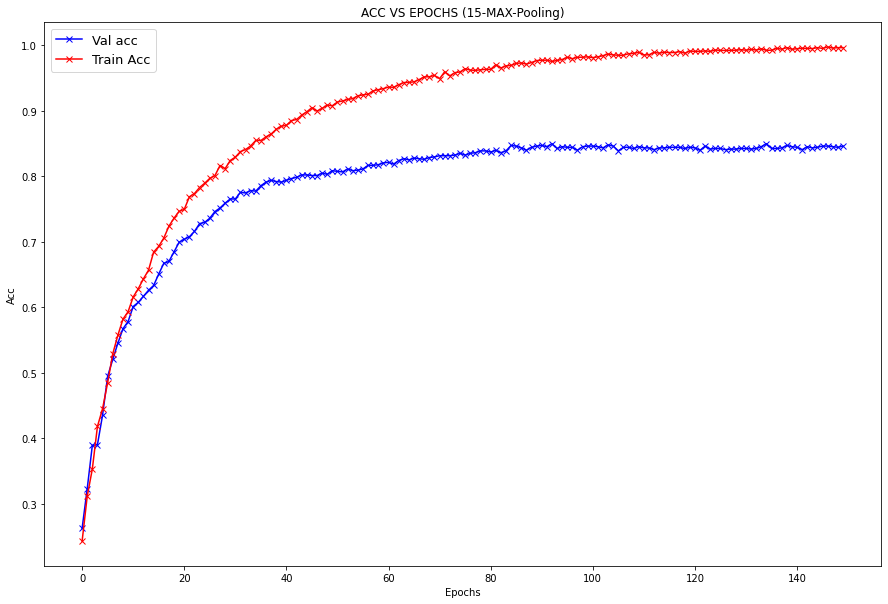

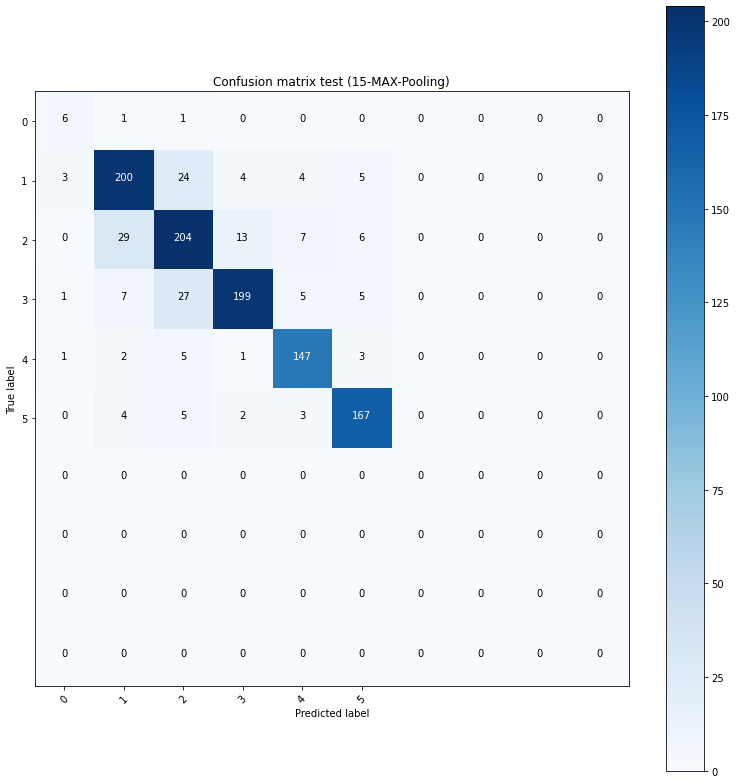

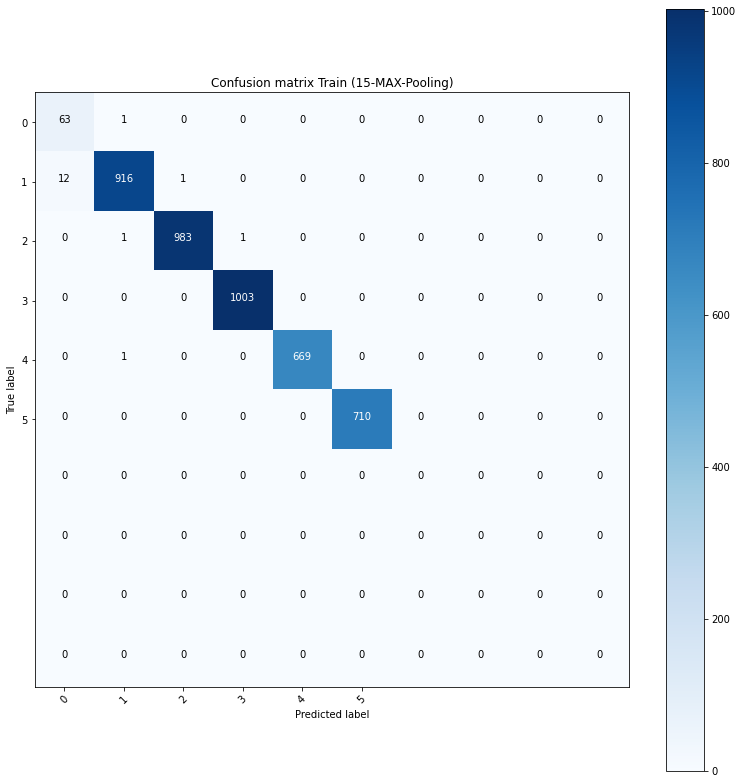

<Figure size 432x288 with 0 Axes>

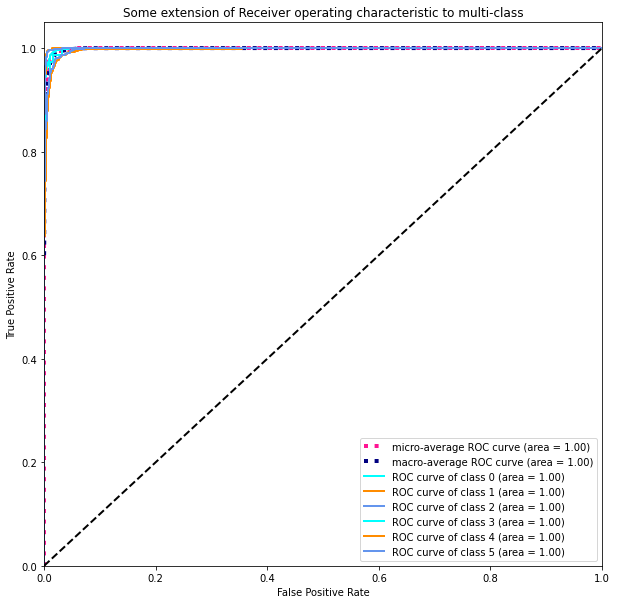

<Figure size 432x288 with 0 Axes>

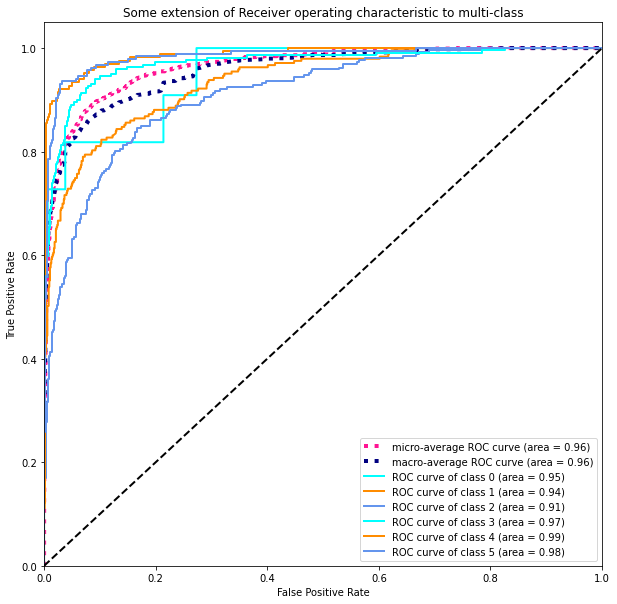

3-local-average
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.230 | Train Acc: 60.25%
	 Val. Loss: 1.220 |  Test. Acc: 60.49%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.813 | Train Acc: 73.61%
	 Val. Loss: 0.846 |  Test. Acc: 71.31%
Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.581 | Train Acc: 82.33%
	 Val. Loss: 0.661 |  Test. Acc: 78.28%
Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.455 | Train Acc: 85.82%
	 Val. Loss: 0.562 |  Test. Acc: 81.03%
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.357 | Train Acc: 89.20%
	 Val. Loss: 0.506 |  Test. Acc: 82.49%
Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.288 | Train Acc: 91.71%
	 Val. Loss: 0.469 |  Test. Acc: 83.50%
Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.234 | Train Acc: 93.57%
	 Val. Loss: 0.446 |  Test. Acc: 84.14%
Epoch: 80 | Epoch Time: 0m 0s
	Train Loss: 0.187 | Train Acc: 95.00%
	 Val. Loss: 0.430 |  Test. Acc: 84.78%
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.160 | Train Acc: 95.92%
	 Val. Loss: 0.422 |  Test. Acc: 84.97%
Epo

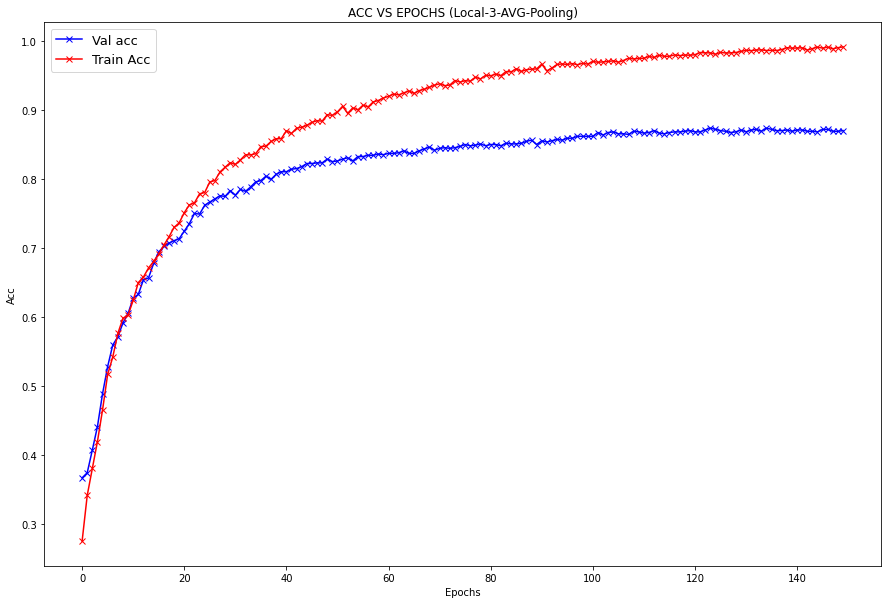

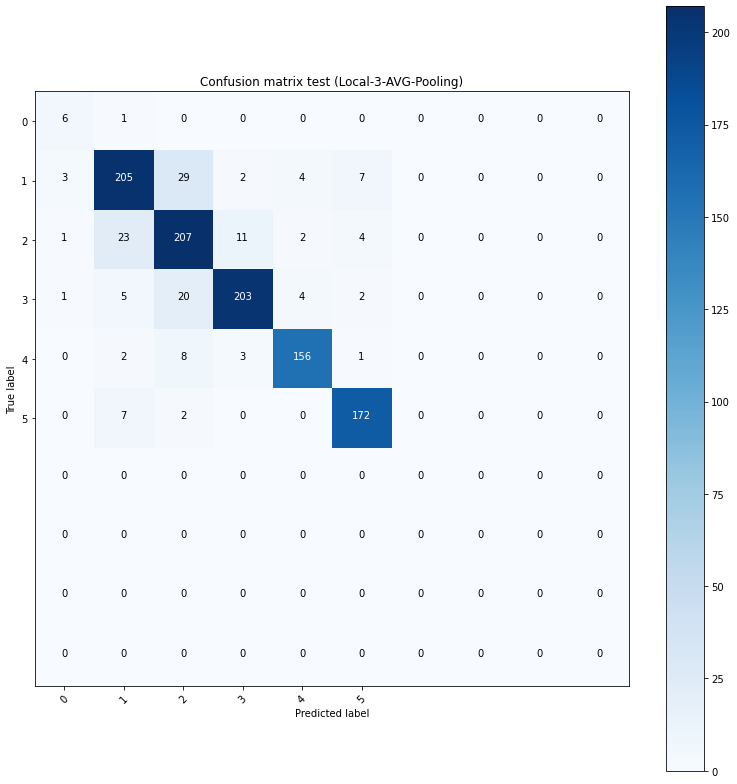

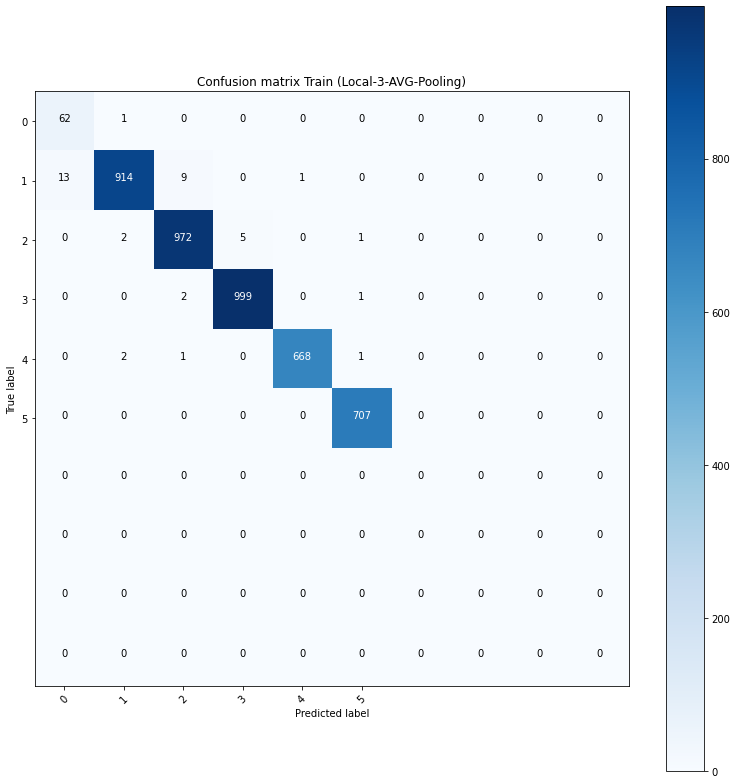

<Figure size 432x288 with 0 Axes>

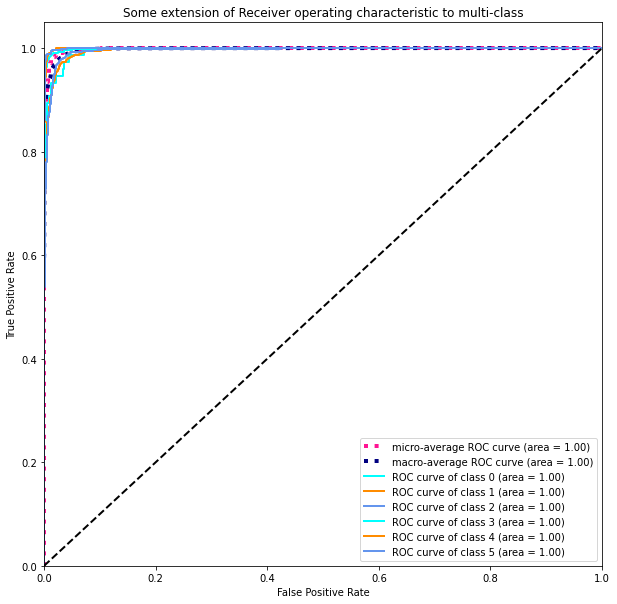

<Figure size 432x288 with 0 Axes>

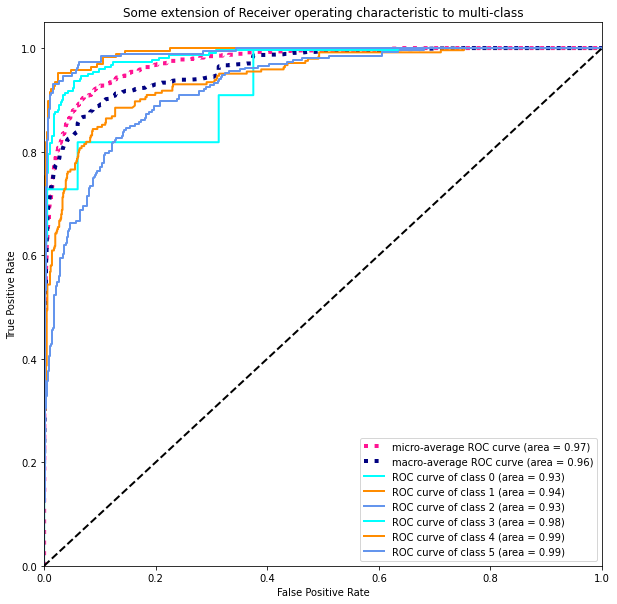

5-local-average
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 1.312 | Train Acc: 58.28%
	 Val. Loss: 1.302 |  Test. Acc: 57.29%
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.927 | Train Acc: 70.01%
	 Val. Loss: 0.961 |  Test. Acc: 68.38%


In [ ]:
enc = OneHotEncoder(sparse=False, categories='auto')
args.pooling_strat = 'max'
model = CNN(text_field.vocab.vectors)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.CrossEntropyLoss().to(device)
model = model.to(device)
train_data, test_data, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test = run(model, modelPath+'1-max-pooling.pkl')
generate_report( train_data, test_data, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test, enc)

args.pooling_strat = 'local'
for pool_size in args.local_pool_size_list:
  args.pooling_filter_size = pool_size
  model = CNN(text_field.vocab.vectors)
  optimizer = optim.Adam(model.parameters(), lr=args.lr)
  criterion = nn.CrossEntropyLoss().to(device)
  model = model.to(device)
  
  train_acc, test_acc, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test = run(model, modelPath+f'{pool_size}-local-max.pkl')
  generate_report(train_acc, test_acc, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test, enc)

args.pooling_strat = 'k-max'
for k in args.k_max_pool_size_list:
  args.pooling_k_size = k
  model = CNN(text_field.vocab.vectors)
  optimizer = optim.Adam(model.parameters(), lr=args.lr)
  criterion = nn.CrossEntropyLoss().to(device)
  model = model.to(device)
  
  train_acc, test_acc, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test = run(model, modelPath+f'{k}-max-pooling.pkl')
  generate_report(train_acc, test_acc, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test, enc)


args.pooling_strat = 'local-average'
for pool_size in args.local_pool_size_list:
  args.pooling_filter_size = pool_size
  model = CNN(text_field.vocab.vectors)
  optimizer = optim.Adam(model.parameters(), lr=args.lr)
  criterion = nn.CrossEntropyLoss().to(device)
  model = model.to(device)
  
  train_acc, test_acc, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test = run(model, modelPath+f'{pool_size}-local-avg-pooling.pkl')
  generate_report(train_acc, test_acc, prob_pred_train, prob_pred_test, pred_train, pred_test, true_train, true_test, enc)

## Load model

In [ ]:
def loader(path):
  PATH = modelPath+path
  model2 = CNN(text_field.vocab.vectors)
  if device.type == 'cpu':
    model2.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
  else:
    model2.load_state_dict(torch.load(PATH))
  model2.eval()
args.pooling_strat = 'max'
model = loader('1-max-pooling.pkl')

args.pooling_strat = 'local'
for pool_size in args.local_pool_size_list:
  args.pooling_filter_size = pool_size
  loader(f'{pool_size}-local-max.pkl')
  

args.pooling_strat = 'k-max'
for k in args.k_max_pool_size_list:
  args.pooling_k_size = k
  loader(f'{k}-max-pooling.pkl')

args.pooling_strat = 'local-average'
for pool_size in args.local_pool_size_list:
  args.pooling_filter_size = pool_size
  loader(f'{pool_size}-local-avg-pooling.pkl')